In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager
from utils.codificication_mlp import Layer, Cromosome, Fitness        

from time import time

Using TensorFlow backend.


In [2]:
def time_measure(chrom, iters=50):
    '''
    Function tu mesure the training time of a model
    '''
    times = []
    for i in range(iters):
        ti = time()
        c.fitness()
        times.append(time() - ti)
    return times



### Test the capability of a neural network with a single layer

In [5]:
c = Cromosome([Layer(930, 'prelu', 0.654)])


# Fitness params
epochs = 75
batch_size = 256
verbose = 1
redu_plat = False
early_stop = True

# dataset params:
dataset = 'mnist'
classes = []

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, 
                   epochs=epochs, early_stop=early_stop)

(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 930)               730050    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 930)               930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 930)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                9310      
Total params: 740,290
Trainable params: 740,290
Non-trainable params: 0
_________________________________________________________________
Trai

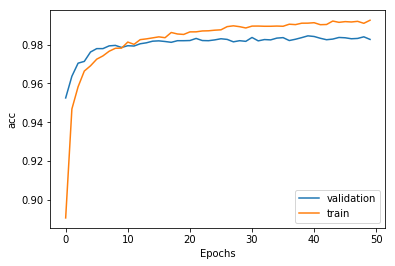

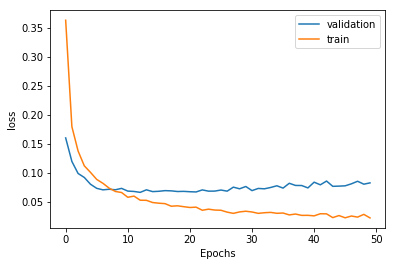

0.9845

In [6]:
c.fitness()

#### training time measurement when resetting VRAM memory

In [3]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])

# params:
dataset = 'mnist'
classes = [4, 9]
epochs = 2

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs)

t_with_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_with_reset), np.std(t_with_reset)))

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples
mean time:	1.326
std:	1.473


In [4]:
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs, reset=False)

t_without_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_without_reset), np.std(t_without_reset)))

mean time:	2.145
std:	0.610


In [ ]:
from scipy import stats
t_value, p_value = stats.ttest_ind(t_without_reset, t_with_reset)
print("T-value: %0.3f " % t_value)
print("P-value: %0.3f " % p_value)

#### A little class to test the Parent Selector Objects

In [5]:
class A:
    def __init__(self, N_participants=3):
        self.N = N_participants
        self.history_fitness = {}
        
    def set_params(self,maximize, history):
        self.maximize = maximize
        self.history_fitness = history
        
    def eval_individual(self, chrom):
        gen = chrom.__repr__()
        if gen not in self.history_fitness.keys():
            self.history_fitness[gen] = chrom.fitness()
        elif chrom.fit is None:
            chrom.fit = self.history_fitness[gen]
        return chrom.fit
    
    def get_one_offspring(self, population):
        idxs = np.linspace(0, len(population) - 1, len(population)).astype(np.int32)
        idxs_perm = np.random.permutation(idxs)
        participants_1 = [population[idxs_perm[i]] for i in range(self.N)]
        participants_2 = [population[idxs_perm[-i]] for i in range(1, self.N + 1)]
        win_1 = np.argmax([self.eval_individual(chrom) for chrom in participants_1])
        win_2 = np.argmax([self.eval_individual(chrom) for chrom in participants_2])
        parent1 = participants_1[win_1]
        parent2 = participants_2[win_2]
        offspring = parent1.cross(parent2)
        offspring.mutate()
        self.eval_individual(offspring)
        return offspring, (parent1, parent2)
        
    def next_gen(self, population, num_offspring=1):
        next_generation = []
        all_parents = []
        for n in range(num_offspring):
            print(len(population))
            offspring, parents = self.get_one_offspring(population)
            next_generation.append(offspring)
            all_parents.append(parents)
        return next_generation, all_parents
    
class B:
    def __init__(self, n):
        self.n = n
        self.fit = self.n
        
    def __repr__(self):
        return str(self.n)

    def fitness(self):
        return self.n
    
    def cross(self, aB):
        return B(np.mean([self.n, aB.n]))
    
    def mutate(self):
        self.n += np.random.rand()*0
        
a = [0,1,2,3,4,5,6,7,8,9,10]
b = [B(aux) for aux in a]

# Test LinealOrder
a_ = LinealOrder()
next_generation, all_parents = a_.next_gen(b, 10000)

### Optimize a 2D - function with GA

Chromosome to minimize the fuction:

\begin{equation}
f(x) = x \cdot sin(4x) + 1.1  y \cdot sin(2y)
\end{equation}

In [4]:
class chrom:
    def __init__(self, x=0, y=0, mutation_prob=0.2):
        self.x = x
        self.y = y
        self.mut_prob = mutation_prob
        self.fit = None
    
    def set_fitness(self, fit):
        self.evaluator = fit
        
    def random_indiv(self):
        x = 10 * np.random.rand()
        y = 10 * np.random.rand()
        return chrom(x, y)
    
    def simple_indiv(self):
        return chrom(0, 0)
        
    def cross(self, other_cromosome):
        bx = np.random.rand()
        by = np.random.rand()
        x = bx * self.x + (1 - bx) * other_cromosome.x
        y = by * self.y + (1 - by) * other_cromosome.y
        return chrom(x, y)
        
    
    def mutate(self):
        if np.random.rand() < self.mut_prob:
            self.x = 10 * np.random.rand()
        if np.random.rand() < self.mut_prob:
            self.y = 10 * np.random.rand()
            
    def equals(self, other_cromosome):
        return (self.x == other_cromosome.x) and (self.y == other_cromosome.y)
    
    def __repr__(self):
        return "(%0.3f, %0.3f)" % (self.x, self.y)
    
    def fitness(self):
        self.fit = self.x * np.sin(4 * self.x) + 1.1 * self.y * np.sin(2 * self.y)
        return self.fit
    
    def cross_val(self):
        return [self.fitness() for i in range(4)]

In [7]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5

c = chrom(mutation_prob=mut_prob)
ps = [RandomParentSelector(), LinealOrder(), LinealOrderII(), WheelSelection(), TournamentSelection(5)]
p = ps[2]
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

winner, best_fit, ranking = generational.evolve(show=False)
print(best_fit)
print(winner)

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
-18.54115976408368
(9.027, 8.681)


-18.554716504097726 19.861786404025292


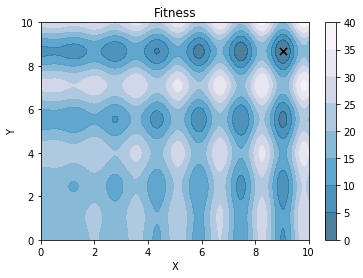

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(0, 10.0, N)
y = np.linspace(0, 10.0, N)

X, Y = np.meshgrid(x, y)
z = X * np.sin(4 * X) + 1.1 * Y * np.sin(2 * Y) 
print(np.min(z), np.max(z))
z += np.abs(np.min(z))
min_z = np.min(z)
max_z = np.max(z)
max_idxs = []
min_idxs = []
for i in range(N):
    for k in range(N):
        if z[i, k] == min_z:
            min_idxs.append((i, k))
        elif z[i, k] == max_z:
            max_idxs.append((i, k))

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in max_idxs:
    continue
    plt.scatter(x[k], y[i], c='r', label='max', s=20)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=50, marker='x')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitness')
ax.set_ylim((np.min(Y), np.max(Y)))
cbar = fig.colorbar(cs)
plt.show()

In [14]:
h = generational.population_history
def scatter_pop(h, generation, ax):
    for p in h[generation]:
        ax.scatter(p.x, p.y, c='g', label='min', s=100)
        
print(len(h), generations)

101 100


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((np.min(X), np.max(X)))
ax.set_ylim((np.min(Y), np.max(Y)))
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=100, marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
title = ax.set_title('')
plt.close(fig)
            
def animate2(i):
    ax.cla()
    ax.set_title('generation %s' % str(i).zfill(4))
    cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
    for i_, k_ in min_idxs:
        ax.scatter(x[k_], y[i_], c='k', label='min', s=100, marker='x')
    ax.set_xlim((np.min(X), np.max(X)))
    ax.set_ylim((np.min(Y), np.max(Y)))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    scatter_pop(h, i, ax)
    return

In [ ]:
anim = animation.FuncAnimation(fig,
                               animate2,
                               init_func=None,
                               frames=generations,
                               interval=100000)

# Set up formatting for the movie files
Writer = animation.writers['imagemagick']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/home/daniel/proyectos/Tesis/project/GA/NeuroEvolution/anim2.gif', writer=writer)

In [21]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5
iters = 100

c = chrom(mutation_prob=mut_prob)

ps = {'random':RandomParentSelector(), 'linealI':LinealOrder(), 'linealII':LinealOrderII(), 
      'wheel':WheelSelection(), 'tournament5': TournamentSelection(5), 'tournament3': TournamentSelection(3)}

all_fits = {}
for key in ps.keys():
    if key == 'wheel':
        continue
    print("Evaluating " + key + " parent selector")
    p = ps[key]
    all_fits[key] = []
    for i in range(iters):
        generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

        winner, best_fit, ranking = generational.evolve(show=False)
        all_fits[key].append(best_fit)



Evaluating randomparent selector
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algor

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Evaluating tournament3parent selector
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic 

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

In [22]:
for key, value in all_fits.items():
    print(key,"score: %0.4f  +-  %0.4f" % (np.mean(value), np.std(value)))

random score: -25.5032  +-  6.1512
linealI score: -26.0051  +-  5.4390
linealII score: -26.4715  +-  5.4950
tournament5 score: -27.9516  +-  5.6047
tournament3 score: -27.3675  +-  6.1080


### Lineal Order I

\begin{equation}
SelectionProb_i = \frac{Position_i}{\sum_{j}{Position_j}}
\end{equation}

### Lineal Order II

\begin{equation}
SelectionProb_i = \frac{N_{keep} - Position_i + 1}{\sum_{j}^{N_{keep}}{Position_j}}
\end{equation}

### Load variations of MNIST

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [192]:
def get_mnist_variations(folder, data):
    file_list = [f for f in os.listdir(folder) if f[-3:]!='zip']
    files = {'MB':'mnist',
             'MBI':'mnist_background_images',
             'MRB':'mnist_background_random',
             'MRD':'mnist_rotation_new',
             'MRDBI':'mnist_rotation_back_image_new'}
    T_mode = {'MB':False,
             'MBI':True,
             'MRB':True,
             'MRD':True,
             'MRDBI':True}
    assert data in files.keys()
    dataset = files[data]
    folder_datasets = os.path.join(folder, dataset)
    datasets = os.listdir(folder_datasets)
    file_train = os.path.join(folder_datasets, [d for d in datasets if 'train' in d][0])
    file_test  = os.path.join(folder_datasets, [d for d in datasets if 'test'  in d][0])

        
    def get_XY(file):
        with open(file, 'r') as f:
            X, Y = [], []
            for c, line in enumerate(f):
                array = line.split(' ')
                array = [float(l) for l in array if len(l)>0]
                array = np.array(array)
                Y.append(int(array[-1]))
                if T_mode[data]:
                    X.append(array[:-1].reshape(28, 28).T)
                else:
                    X.append(array[:-1].reshape(28, 28))
        return np.array(X), np.array(Y, dtype=np.int32)

    x_train, y_train = get_XY(file_train)
    x_test , y_test  = get_XY(file_test)
    return (x_train, y_train), (x_test, y_test)
    
    


In [230]:
folder = '../../../../../datasets/MNIST_variations'
data = 'MRDBI'
(x_train, y_train), (x_test, y_test) = get_mnist_variations(folder, data)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(12000, 28, 28) (12000,)
(50000, 28, 28) (50000,)


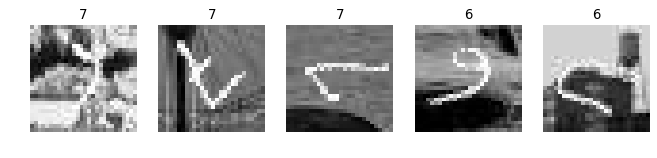

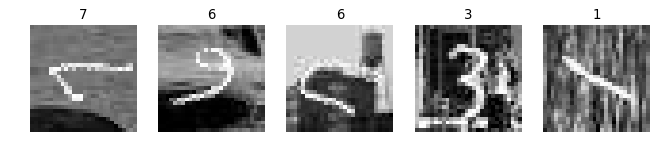

In [231]:
from matplotlib.pyplot import figure

N = 2
n = 5
for k in range(N):
    figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(x_train[N * k + i,...], cmap='gray')
        plt.title(y_train[N * k + i])
        plt.axis('off')
plt.show()


### Train and evaluato models on MNIST's variants 

In [1]:
from utils.datamanager import DataManager
from utils.codificication_mlp import Layer, Cromosome, Fitness        

from time import time

# Fitness params
epochs = 50000
batch_size = 128
verbose = 1
redu_plat = False
early_stop = True

# dataset params:
dataset = 'MB'
folder = '../../../../../datasets/MNIST_variations'
classes = []

fitness = Fitness.get_instance()


Using TensorFlow backend.


----------  DATASET MB  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/50000
9600/9600 [==============================] - 1s 99us/step - loss: 2.2963 - acc: 0.3405 - val_loss: 2.2893 - val_acc: 0.4321
Epoch 2/50000
9600/9600 [==============================

9600/9600 [==============================] - 0s 16us/step - loss: 1.7415 - acc: 0.7420 - val_loss: 1.7217 - val_acc: 0.7462
Epoch 54/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7325 - acc: 0.7418 - val_loss: 1.7125 - val_acc: 0.7500
Epoch 55/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.7236 - acc: 0.7434 - val_loss: 1.7034 - val_acc: 0.7496
Epoch 56/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.7148 - acc: 0.7445 - val_loss: 1.6944 - val_acc: 0.7496
Epoch 57/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7060 - acc: 0.7455 - val_loss: 1.6855 - val_acc: 0.7525
Epoch 58/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6973 - acc: 0.7483 - val_loss: 1.6765 - val_acc: 0.7529
Epoch 59/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6886 - acc: 0.7515 - val_loss: 1.6677 - val_acc: 0.7563
Epoch 60/50000
9600/9600 [================

Epoch 112/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3067 - acc: 0.7914 - val_loss: 1.2790 - val_acc: 0.8037
Epoch 113/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3008 - acc: 0.7934 - val_loss: 1.2731 - val_acc: 0.8054
Epoch 114/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.2950 - acc: 0.7940 - val_loss: 1.2671 - val_acc: 0.8054
Epoch 115/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.2892 - acc: 0.7938 - val_loss: 1.2613 - val_acc: 0.8050
Epoch 116/50000
9600/9600 [==============================] - 0s 37us/step - loss: 1.2834 - acc: 0.7948 - val_loss: 1.2554 - val_acc: 0.8054
Epoch 117/50000
9600/9600 [==============================] - 0s 38us/step - loss: 1.2777 - acc: 0.7957 - val_loss: 1.2495 - val_acc: 0.8058
Epoch 118/50000
9600/9600 [==============================] - 0s 38us/step - loss: 1.2720 - acc: 0.7963 - val_loss: 1.2438 - val_acc: 0.8063
Epoch 119/50000
9600

9600/9600 [==============================] - 0s 16us/step - loss: 1.0283 - acc: 0.8214 - val_loss: 0.9983 - val_acc: 0.8308
Epoch 171/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.0245 - acc: 0.8219 - val_loss: 0.9945 - val_acc: 0.8317
Epoch 172/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.0207 - acc: 0.8221 - val_loss: 0.9907 - val_acc: 0.8317
Epoch 173/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.0169 - acc: 0.8229 - val_loss: 0.9869 - val_acc: 0.8317
Epoch 174/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.0132 - acc: 0.8228 - val_loss: 0.9832 - val_acc: 0.8321
Epoch 175/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.0095 - acc: 0.8234 - val_loss: 0.9795 - val_acc: 0.8321
Epoch 176/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0058 - acc: 0.8232 - val_loss: 0.9758 - val_acc: 0.8321
Epoch 177/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 0.8465 - acc: 0.8406 - val_loss: 0.8172 - val_acc: 0.8467
Epoch 229/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8440 - acc: 0.8405 - val_loss: 0.8148 - val_acc: 0.8462
Epoch 230/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8415 - acc: 0.8408 - val_loss: 0.8123 - val_acc: 0.8475
Epoch 231/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8390 - acc: 0.8416 - val_loss: 0.8098 - val_acc: 0.8479
Epoch 232/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8365 - acc: 0.8417 - val_loss: 0.8074 - val_acc: 0.8479
Epoch 233/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.8340 - acc: 0.8417 - val_loss: 0.8049 - val_acc: 0.8483
Epoch 234/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8316 - acc: 0.8422 - val_loss: 0.8025 - val_acc: 0.8483
Epoch 235/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 0.7242 - acc: 0.8560 - val_loss: 0.6970 - val_acc: 0.8596
Epoch 287/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.7224 - acc: 0.8565 - val_loss: 0.6953 - val_acc: 0.8592
Epoch 288/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.7207 - acc: 0.8565 - val_loss: 0.6936 - val_acc: 0.8592
Epoch 289/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.7190 - acc: 0.8567 - val_loss: 0.6919 - val_acc: 0.8592
Epoch 290/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.7173 - acc: 0.8570 - val_loss: 0.6903 - val_acc: 0.8596
Epoch 291/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.7156 - acc: 0.8568 - val_loss: 0.6887 - val_acc: 0.8617
Epoch 292/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.7139 - acc: 0.8570 - val_loss: 0.6870 - val_acc: 0.8604
Epoch 293/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 0.6390 - acc: 0.8688 - val_loss: 0.6144 - val_acc: 0.8687
Epoch 345/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.6378 - acc: 0.8691 - val_loss: 0.6132 - val_acc: 0.8692
Epoch 346/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.6365 - acc: 0.8691 - val_loss: 0.6120 - val_acc: 0.8692
Epoch 347/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.6353 - acc: 0.8692 - val_loss: 0.6109 - val_acc: 0.8687
Epoch 348/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.6341 - acc: 0.8692 - val_loss: 0.6097 - val_acc: 0.8696
Epoch 349/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.6329 - acc: 0.8694 - val_loss: 0.6086 - val_acc: 0.8692
Epoch 350/50000
9600/9600 [==============================] - 0s 20us/step - loss: 0.6317 - acc: 0.8694 - val_loss: 0.6074 - val_acc: 0.8700
Epoch 351/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 18us/step - loss: 0.5773 - acc: 0.8762 - val_loss: 0.5555 - val_acc: 0.8750
Epoch 403/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5764 - acc: 0.8764 - val_loss: 0.5546 - val_acc: 0.8758
Epoch 404/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5755 - acc: 0.8764 - val_loss: 0.5537 - val_acc: 0.8754
Epoch 405/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5746 - acc: 0.8760 - val_loss: 0.5529 - val_acc: 0.8750
Epoch 406/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5737 - acc: 0.8760 - val_loss: 0.5520 - val_acc: 0.8758
Epoch 407/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5728 - acc: 0.8764 - val_loss: 0.5511 - val_acc: 0.8758
Epoch 408/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5719 - acc: 0.8762 - val_loss: 0.5503 - val_acc: 0.8758
Epoch 409/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 20us/step - loss: 0.5311 - acc: 0.8812 - val_loss: 0.5118 - val_acc: 0.8787
Epoch 461/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.5304 - acc: 0.8817 - val_loss: 0.5112 - val_acc: 0.8792
Epoch 462/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.5297 - acc: 0.8816 - val_loss: 0.5105 - val_acc: 0.8787
Epoch 463/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5290 - acc: 0.8816 - val_loss: 0.5099 - val_acc: 0.8792
Epoch 464/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5284 - acc: 0.8818 - val_loss: 0.5092 - val_acc: 0.8796
Epoch 465/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5277 - acc: 0.8818 - val_loss: 0.5086 - val_acc: 0.8792
Epoch 466/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.5270 - acc: 0.8821 - val_loss: 0.5080 - val_acc: 0.8800
Epoch 467/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 35us/step - loss: 0.4954 - acc: 0.8863 - val_loss: 0.4786 - val_acc: 0.8821
Epoch 519/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.4949 - acc: 0.8871 - val_loss: 0.4782 - val_acc: 0.8821
Epoch 520/50000
9600/9600 [==============================] - 0s 26us/step - loss: 0.4943 - acc: 0.8867 - val_loss: 0.4776 - val_acc: 0.8821
Epoch 521/50000
9600/9600 [==============================] - 0s 20us/step - loss: 0.4938 - acc: 0.8870 - val_loss: 0.4771 - val_acc: 0.8821
Epoch 522/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4933 - acc: 0.8865 - val_loss: 0.4766 - val_acc: 0.8821
Epoch 523/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4927 - acc: 0.8867 - val_loss: 0.4761 - val_acc: 0.8821
Epoch 524/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4922 - acc: 0.8868 - val_loss: 0.4757 - val_acc: 0.8821
Epoch 525/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 21us/step - loss: 0.4672 - acc: 0.8902 - val_loss: 0.4527 - val_acc: 0.8858
Epoch 577/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.4668 - acc: 0.8899 - val_loss: 0.4523 - val_acc: 0.8863
Epoch 578/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4664 - acc: 0.8901 - val_loss: 0.4519 - val_acc: 0.8863
Epoch 579/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4659 - acc: 0.8903 - val_loss: 0.4515 - val_acc: 0.8858
Epoch 580/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4655 - acc: 0.8903 - val_loss: 0.4511 - val_acc: 0.8863
Epoch 581/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4651 - acc: 0.8903 - val_loss: 0.4507 - val_acc: 0.8858
Epoch 582/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.4646 - acc: 0.8902 - val_loss: 0.4503 - val_acc: 0.8858
Epoch 583/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 19us/step - loss: 0.4444 - acc: 0.8928 - val_loss: 0.4319 - val_acc: 0.8904
Epoch 635/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.4440 - acc: 0.8931 - val_loss: 0.4316 - val_acc: 0.8904
Epoch 636/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.4437 - acc: 0.8930 - val_loss: 0.4313 - val_acc: 0.8904
Epoch 637/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.4433 - acc: 0.8932 - val_loss: 0.4310 - val_acc: 0.8904
Epoch 638/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4430 - acc: 0.8934 - val_loss: 0.4307 - val_acc: 0.8904
Epoch 639/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.4426 - acc: 0.8930 - val_loss: 0.4303 - val_acc: 0.8900
Epoch 640/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.4423 - acc: 0.8930 - val_loss: 0.4300 - val_acc: 0.8904
Epoch 641/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 0.4255 - acc: 0.8959 - val_loss: 0.4150 - val_acc: 0.8917
Epoch 693/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4252 - acc: 0.8953 - val_loss: 0.4147 - val_acc: 0.8917
Epoch 694/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4249 - acc: 0.8959 - val_loss: 0.4145 - val_acc: 0.8917
Epoch 695/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4246 - acc: 0.8958 - val_loss: 0.4142 - val_acc: 0.8917
Epoch 696/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4243 - acc: 0.8965 - val_loss: 0.4140 - val_acc: 0.8917
Epoch 697/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4241 - acc: 0.8958 - val_loss: 0.4137 - val_acc: 0.8917
Epoch 698/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4237 - acc: 0.8958 - val_loss: 0.4134 - val_acc: 0.8917
Epoch 699/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 0.4096 - acc: 0.8977 - val_loss: 0.4009 - val_acc: 0.8954
Epoch 751/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4094 - acc: 0.8980 - val_loss: 0.4007 - val_acc: 0.8958
Epoch 752/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4091 - acc: 0.8981 - val_loss: 0.4005 - val_acc: 0.8958
Epoch 753/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4089 - acc: 0.8980 - val_loss: 0.4003 - val_acc: 0.8958
Epoch 754/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.4086 - acc: 0.8980 - val_loss: 0.4000 - val_acc: 0.8958
Epoch 755/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.4084 - acc: 0.8985 - val_loss: 0.3999 - val_acc: 0.8958
Epoch 756/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.4082 - acc: 0.8988 - val_loss: 0.3996 - val_acc: 0.8958
Epoch 757/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 36us/step - loss: 0.3961 - acc: 0.9010 - val_loss: 0.3890 - val_acc: 0.8967
Epoch 809/50000
9600/9600 [==============================] - 0s 22us/step - loss: 0.3959 - acc: 0.9010 - val_loss: 0.3889 - val_acc: 0.8967
Epoch 810/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3956 - acc: 0.9013 - val_loss: 0.3887 - val_acc: 0.8971
Epoch 811/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.3954 - acc: 0.9010 - val_loss: 0.3885 - val_acc: 0.8967
Epoch 812/50000
9600/9600 [==============================] - 0s 23us/step - loss: 0.3952 - acc: 0.9010 - val_loss: 0.3883 - val_acc: 0.8967
Epoch 813/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.3950 - acc: 0.9013 - val_loss: 0.3882 - val_acc: 0.8967
Epoch 814/50000
9600/9600 [==============================] - 0s 20us/step - loss: 0.3948 - acc: 0.9013 - val_loss: 0.3880 - val_acc: 0.8967
Epoch 815/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 0.3844 - acc: 0.9027 - val_loss: 0.3789 - val_acc: 0.8983
Epoch 867/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3842 - acc: 0.9029 - val_loss: 0.3788 - val_acc: 0.8983
Epoch 868/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3840 - acc: 0.9028 - val_loss: 0.3786 - val_acc: 0.8983
Epoch 869/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3838 - acc: 0.9027 - val_loss: 0.3785 - val_acc: 0.8983
Epoch 870/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3836 - acc: 0.9029 - val_loss: 0.3783 - val_acc: 0.8983
Epoch 871/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3834 - acc: 0.9028 - val_loss: 0.3781 - val_acc: 0.8983
Epoch 872/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3832 - acc: 0.9028 - val_loss: 0.3780 - val_acc: 0.8983
Epoch 873/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 23us/step - loss: 0.3741 - acc: 0.9040 - val_loss: 0.3702 - val_acc: 0.9008
Epoch 925/50000
9600/9600 [==============================] - 0s 22us/step - loss: 0.3739 - acc: 0.9042 - val_loss: 0.3701 - val_acc: 0.9008
Epoch 926/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.3737 - acc: 0.9041 - val_loss: 0.3699 - val_acc: 0.9008
Epoch 927/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.3736 - acc: 0.9043 - val_loss: 0.3698 - val_acc: 0.9008
Epoch 928/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3734 - acc: 0.9043 - val_loss: 0.3697 - val_acc: 0.9008
Epoch 929/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3733 - acc: 0.9042 - val_loss: 0.3695 - val_acc: 0.9008
Epoch 930/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.3731 - acc: 0.9039 - val_loss: 0.3694 - val_acc: 0.9008
Epoch 931/50000
9600/9600 [=========

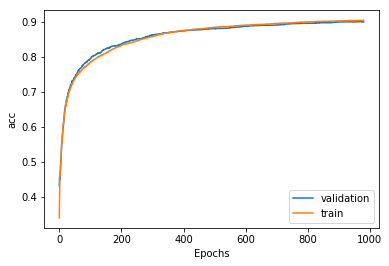

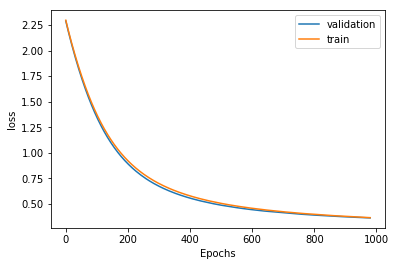

----------  DATASET MBI  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/50000
9600/9600 [==============================] - 0s 28us/step - loss: 2.3007 - acc: 0.1140 - val_loss: 2.2989 - val_acc: 0.1129
Epoch 2/50000
9600/9600 [=============================

9600/9600 [==============================] - 0s 16us/step - loss: 2.1536 - acc: 0.4949 - val_loss: 2.1530 - val_acc: 0.4958
Epoch 54/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1510 - acc: 0.5023 - val_loss: 2.1501 - val_acc: 0.5021
Epoch 55/50000
9600/9600 [==============================] - 0s 20us/step - loss: 2.1483 - acc: 0.4975 - val_loss: 2.1476 - val_acc: 0.5017
Epoch 56/50000
9600/9600 [==============================] - 0s 18us/step - loss: 2.1457 - acc: 0.5016 - val_loss: 2.1448 - val_acc: 0.5029
Epoch 57/50000
9600/9600 [==============================] - 0s 19us/step - loss: 2.1431 - acc: 0.5061 - val_loss: 2.1422 - val_acc: 0.5042
Epoch 58/50000
9600/9600 [==============================] - 0s 23us/step - loss: 2.1405 - acc: 0.5093 - val_loss: 2.1396 - val_acc: 0.5138
Epoch 59/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1378 - acc: 0.5216 - val_loss: 2.1370 - val_acc: 0.5167
Epoch 60/50000
9600/9600 [================

Epoch 112/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0080 - acc: 0.5808 - val_loss: 2.0071 - val_acc: 0.5763
Epoch 113/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0057 - acc: 0.5834 - val_loss: 2.0048 - val_acc: 0.5787
Epoch 114/50000
9600/9600 [==============================] - 0s 18us/step - loss: 2.0034 - acc: 0.5827 - val_loss: 2.0024 - val_acc: 0.5796
Epoch 115/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0011 - acc: 0.5820 - val_loss: 2.0003 - val_acc: 0.5829
Epoch 116/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.9989 - acc: 0.5854 - val_loss: 1.9979 - val_acc: 0.5800
Epoch 117/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.9966 - acc: 0.5872 - val_loss: 1.9957 - val_acc: 0.5787
Epoch 118/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.9944 - acc: 0.5841 - val_loss: 1.9934 - val_acc: 0.5796
Epoch 119/50000
9600

9600/9600 [==============================] - 0s 17us/step - loss: 1.8843 - acc: 0.6114 - val_loss: 1.8833 - val_acc: 0.6092
Epoch 171/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.8824 - acc: 0.6112 - val_loss: 1.8813 - val_acc: 0.6113
Epoch 172/50000
9600/9600 [==============================] - 0s 21us/step - loss: 1.8804 - acc: 0.6142 - val_loss: 1.8796 - val_acc: 0.6108
Epoch 173/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.8785 - acc: 0.6169 - val_loss: 1.8774 - val_acc: 0.6125
Epoch 174/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.8764 - acc: 0.6142 - val_loss: 1.8756 - val_acc: 0.6104
Epoch 175/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.8745 - acc: 0.6130 - val_loss: 1.8738 - val_acc: 0.6121
Epoch 176/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.8726 - acc: 0.6136 - val_loss: 1.8717 - val_acc: 0.6138
Epoch 177/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 19us/step - loss: 1.7772 - acc: 0.6331 - val_loss: 1.7764 - val_acc: 0.6304
Epoch 229/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7755 - acc: 0.6354 - val_loss: 1.7748 - val_acc: 0.6279
Epoch 230/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7738 - acc: 0.6332 - val_loss: 1.7728 - val_acc: 0.6325
Epoch 231/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7720 - acc: 0.6350 - val_loss: 1.7713 - val_acc: 0.6321
Epoch 232/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.7704 - acc: 0.6365 - val_loss: 1.7697 - val_acc: 0.6300
Epoch 233/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.7687 - acc: 0.6365 - val_loss: 1.7682 - val_acc: 0.6325
Epoch 234/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7670 - acc: 0.6343 - val_loss: 1.7663 - val_acc: 0.6325
Epoch 235/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.6846 - acc: 0.6473 - val_loss: 1.6844 - val_acc: 0.6454
Epoch 287/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.6831 - acc: 0.6473 - val_loss: 1.6830 - val_acc: 0.6446
Epoch 288/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.6816 - acc: 0.6474 - val_loss: 1.6817 - val_acc: 0.6462
Epoch 289/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6802 - acc: 0.6489 - val_loss: 1.6802 - val_acc: 0.6458
Epoch 290/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6787 - acc: 0.6480 - val_loss: 1.6786 - val_acc: 0.6442
Epoch 291/50000
9600/9600 [==============================] - 0s 21us/step - loss: 1.6773 - acc: 0.6480 - val_loss: 1.6772 - val_acc: 0.6471
Epoch 292/50000
9600/9600 [==============================] - 0s 25us/step - loss: 1.6758 - acc: 0.6489 - val_loss: 1.6759 - val_acc: 0.6475
Epoch 293/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 21us/step - loss: 1.6042 - acc: 0.6579 - val_loss: 1.6048 - val_acc: 0.6604
Epoch 345/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.6029 - acc: 0.6582 - val_loss: 1.6037 - val_acc: 0.6604
Epoch 346/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.6016 - acc: 0.6582 - val_loss: 1.6023 - val_acc: 0.6587
Epoch 347/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.6003 - acc: 0.6583 - val_loss: 1.6010 - val_acc: 0.6613
Epoch 348/50000
9600/9600 [==============================] - 0s 27us/step - loss: 1.5990 - acc: 0.6593 - val_loss: 1.5998 - val_acc: 0.6600
Epoch 349/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.5977 - acc: 0.6578 - val_loss: 1.5985 - val_acc: 0.6596
Epoch 350/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5964 - acc: 0.6586 - val_loss: 1.5973 - val_acc: 0.6592
Epoch 351/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 18us/step - loss: 1.5342 - acc: 0.6642 - val_loss: 1.5358 - val_acc: 0.6625
Epoch 403/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.5330 - acc: 0.6651 - val_loss: 1.5348 - val_acc: 0.6612
Epoch 404/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5319 - acc: 0.6646 - val_loss: 1.5336 - val_acc: 0.6617
Epoch 405/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5308 - acc: 0.6649 - val_loss: 1.5323 - val_acc: 0.6625
Epoch 406/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5297 - acc: 0.6650 - val_loss: 1.5315 - val_acc: 0.6629
Epoch 407/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5286 - acc: 0.6649 - val_loss: 1.5304 - val_acc: 0.6617
Epoch 408/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.5275 - acc: 0.6652 - val_loss: 1.5293 - val_acc: 0.6612
Epoch 409/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.4736 - acc: 0.6697 - val_loss: 1.4764 - val_acc: 0.6675
Epoch 461/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.4726 - acc: 0.6699 - val_loss: 1.4753 - val_acc: 0.6679
Epoch 462/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.4717 - acc: 0.6705 - val_loss: 1.4743 - val_acc: 0.6658
Epoch 463/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.4707 - acc: 0.6701 - val_loss: 1.4734 - val_acc: 0.6683
Epoch 464/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4697 - acc: 0.6697 - val_loss: 1.4726 - val_acc: 0.6683
Epoch 465/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.4687 - acc: 0.6710 - val_loss: 1.4716 - val_acc: 0.6675
Epoch 466/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.4678 - acc: 0.6708 - val_loss: 1.4707 - val_acc: 0.6671
Epoch 467/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 15us/step - loss: 1.4206 - acc: 0.6758 - val_loss: 1.4246 - val_acc: 0.6708
Epoch 519/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4196 - acc: 0.6771 - val_loss: 1.4238 - val_acc: 0.6704
Epoch 520/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4188 - acc: 0.6754 - val_loss: 1.4227 - val_acc: 0.6700
Epoch 521/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4179 - acc: 0.6764 - val_loss: 1.4220 - val_acc: 0.6708
Epoch 522/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4172 - acc: 0.6752 - val_loss: 1.4212 - val_acc: 0.6708
Epoch 523/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4163 - acc: 0.6761 - val_loss: 1.4203 - val_acc: 0.6717
Epoch 524/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4154 - acc: 0.6769 - val_loss: 1.4194 - val_acc: 0.6704
Epoch 525/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 21us/step - loss: 1.3739 - acc: 0.6817 - val_loss: 1.3790 - val_acc: 0.6742
Epoch 577/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3730 - acc: 0.6804 - val_loss: 1.3784 - val_acc: 0.6758
Epoch 578/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3723 - acc: 0.6804 - val_loss: 1.3776 - val_acc: 0.6758
Epoch 579/50000
9600/9600 [==============================] - 0s 24us/step - loss: 1.3716 - acc: 0.6813 - val_loss: 1.3768 - val_acc: 0.6758
Epoch 580/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3708 - acc: 0.6801 - val_loss: 1.3762 - val_acc: 0.6758
Epoch 581/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.3701 - acc: 0.6813 - val_loss: 1.3754 - val_acc: 0.6750
Epoch 582/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3694 - acc: 0.6808 - val_loss: 1.3747 - val_acc: 0.6767
Epoch 583/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 18us/step - loss: 1.3326 - acc: 0.6866 - val_loss: 1.3391 - val_acc: 0.6783
Epoch 635/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3320 - acc: 0.6849 - val_loss: 1.3385 - val_acc: 0.6796
Epoch 636/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3313 - acc: 0.6875 - val_loss: 1.3379 - val_acc: 0.6788
Epoch 637/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3307 - acc: 0.6875 - val_loss: 1.3376 - val_acc: 0.6787
Epoch 638/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3300 - acc: 0.6853 - val_loss: 1.3367 - val_acc: 0.6788
Epoch 639/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3293 - acc: 0.6865 - val_loss: 1.3359 - val_acc: 0.6779
Epoch 640/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3286 - acc: 0.6867 - val_loss: 1.3353 - val_acc: 0.6788
Epoch 641/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 15us/step - loss: 1.2960 - acc: 0.6917 - val_loss: 1.3037 - val_acc: 0.6825
Epoch 693/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.2953 - acc: 0.6915 - val_loss: 1.3032 - val_acc: 0.6821
Epoch 694/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.2947 - acc: 0.6904 - val_loss: 1.3027 - val_acc: 0.6808
Epoch 695/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.2941 - acc: 0.6923 - val_loss: 1.3022 - val_acc: 0.6813
Epoch 696/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2936 - acc: 0.6920 - val_loss: 1.3016 - val_acc: 0.6829
Epoch 697/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.2931 - acc: 0.6910 - val_loss: 1.3011 - val_acc: 0.6813
Epoch 698/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.2924 - acc: 0.6927 - val_loss: 1.3005 - val_acc: 0.6808
Epoch 699/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 18us/step - loss: 1.2632 - acc: 0.6961 - val_loss: 1.2724 - val_acc: 0.6838
Epoch 751/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.2627 - acc: 0.6967 - val_loss: 1.2720 - val_acc: 0.6838
Epoch 752/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.2622 - acc: 0.6966 - val_loss: 1.2715 - val_acc: 0.6829
Epoch 753/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2616 - acc: 0.6970 - val_loss: 1.2709 - val_acc: 0.6850
Epoch 754/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.2611 - acc: 0.6970 - val_loss: 1.2706 - val_acc: 0.6833
Epoch 755/50000
9600/9600 [==============================] - 0s 26us/step - loss: 1.2605 - acc: 0.6974 - val_loss: 1.2700 - val_acc: 0.6825
Epoch 756/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.2600 - acc: 0.6968 - val_loss: 1.2695 - val_acc: 0.6838
Epoch 757/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 15us/step - loss: 1.2338 - acc: 0.7005 - val_loss: 1.2445 - val_acc: 0.6871
Epoch 809/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2334 - acc: 0.7017 - val_loss: 1.2441 - val_acc: 0.6867
Epoch 810/50000
9600/9600 [==============================] - 0s 26us/step - loss: 1.2329 - acc: 0.6998 - val_loss: 1.2435 - val_acc: 0.6875
Epoch 811/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2324 - acc: 0.7011 - val_loss: 1.2430 - val_acc: 0.6875
Epoch 812/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.2319 - acc: 0.7007 - val_loss: 1.2426 - val_acc: 0.6858
Epoch 813/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2314 - acc: 0.7008 - val_loss: 1.2421 - val_acc: 0.6871
Epoch 814/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.2310 - acc: 0.7005 - val_loss: 1.2417 - val_acc: 0.6867
Epoch 815/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.2075 - acc: 0.7040 - val_loss: 1.2194 - val_acc: 0.6879
Epoch 867/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.2071 - acc: 0.7030 - val_loss: 1.2189 - val_acc: 0.6896
Epoch 868/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2066 - acc: 0.7043 - val_loss: 1.2187 - val_acc: 0.6875
Epoch 869/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2061 - acc: 0.7034 - val_loss: 1.2180 - val_acc: 0.6892
Epoch 870/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2057 - acc: 0.7044 - val_loss: 1.2178 - val_acc: 0.6896
Epoch 871/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2052 - acc: 0.7039 - val_loss: 1.2174 - val_acc: 0.6892
Epoch 872/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2049 - acc: 0.7046 - val_loss: 1.2170 - val_acc: 0.6896
Epoch 873/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.1835 - acc: 0.7071 - val_loss: 1.1968 - val_acc: 0.6925
Epoch 925/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1832 - acc: 0.7066 - val_loss: 1.1966 - val_acc: 0.6921
Epoch 926/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1827 - acc: 0.7068 - val_loss: 1.1962 - val_acc: 0.6921
Epoch 927/50000
9600/9600 [==============================] - 0s 21us/step - loss: 1.1824 - acc: 0.7064 - val_loss: 1.1958 - val_acc: 0.6933
Epoch 928/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.1820 - acc: 0.7060 - val_loss: 1.1953 - val_acc: 0.6925
Epoch 929/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1815 - acc: 0.7071 - val_loss: 1.1950 - val_acc: 0.6929
Epoch 930/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1812 - acc: 0.7071 - val_loss: 1.1946 - val_acc: 0.6917
Epoch 931/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 19us/step - loss: 1.1618 - acc: 0.7096 - val_loss: 1.1765 - val_acc: 0.6946
Epoch 983/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.1614 - acc: 0.7089 - val_loss: 1.1761 - val_acc: 0.6942
Epoch 984/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.1611 - acc: 0.7098 - val_loss: 1.1757 - val_acc: 0.6946
Epoch 985/50000
9600/9600 [==============================] - 0s 27us/step - loss: 1.1607 - acc: 0.7094 - val_loss: 1.1753 - val_acc: 0.6954
Epoch 986/50000
9600/9600 [==============================] - 0s 40us/step - loss: 1.1603 - acc: 0.7096 - val_loss: 1.1750 - val_acc: 0.6950
Epoch 987/50000
9600/9600 [==============================] - 0s 42us/step - loss: 1.1599 - acc: 0.7096 - val_loss: 1.1748 - val_acc: 0.6954
Epoch 988/50000
9600/9600 [==============================] - 0s 41us/step - loss: 1.1596 - acc: 0.7098 - val_loss: 1.1745 - val_acc: 0.6946
Epoch 989/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.1418 - acc: 0.7126 - val_loss: 1.1577 - val_acc: 0.6983
Epoch 1041/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1415 - acc: 0.7127 - val_loss: 1.1576 - val_acc: 0.6971
Epoch 1042/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1412 - acc: 0.7125 - val_loss: 1.1571 - val_acc: 0.6983
Epoch 1043/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1408 - acc: 0.7128 - val_loss: 1.1568 - val_acc: 0.6979
Epoch 1044/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1404 - acc: 0.7129 - val_loss: 1.1566 - val_acc: 0.6975
Epoch 1045/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1402 - acc: 0.7131 - val_loss: 1.1563 - val_acc: 0.6975
Epoch 1046/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1399 - acc: 0.7130 - val_loss: 1.1560 - val_acc: 0.6983
Epoch 1047/50000
9600/9600 [==

9600/9600 [==============================] - 0s 17us/step - loss: 1.1235 - acc: 0.7152 - val_loss: 1.1407 - val_acc: 0.7000
Epoch 1099/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.1232 - acc: 0.7155 - val_loss: 1.1405 - val_acc: 0.7004
Epoch 1100/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1229 - acc: 0.7159 - val_loss: 1.1400 - val_acc: 0.6987
Epoch 1101/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1226 - acc: 0.7150 - val_loss: 1.1399 - val_acc: 0.6996
Epoch 1102/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1223 - acc: 0.7151 - val_loss: 1.1396 - val_acc: 0.7004
Epoch 1103/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1220 - acc: 0.7155 - val_loss: 1.1393 - val_acc: 0.6987
Epoch 1104/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1217 - acc: 0.7154 - val_loss: 1.1391 - val_acc: 0.7004
Epoch 1105/50000
9600/9600 [==

9600/9600 [==============================] - 0s 19us/step - loss: 1.1068 - acc: 0.7178 - val_loss: 1.1253 - val_acc: 0.7042
Epoch 1157/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.1065 - acc: 0.7181 - val_loss: 1.1250 - val_acc: 0.7021
Epoch 1158/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.1062 - acc: 0.7169 - val_loss: 1.1248 - val_acc: 0.7042
Epoch 1159/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.1059 - acc: 0.7171 - val_loss: 1.1245 - val_acc: 0.7037
Epoch 1160/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.1057 - acc: 0.7173 - val_loss: 1.1242 - val_acc: 0.7021
Epoch 1161/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.1054 - acc: 0.7176 - val_loss: 1.1241 - val_acc: 0.7029
Epoch 1162/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.1051 - acc: 0.7174 - val_loss: 1.1238 - val_acc: 0.7033
Epoch 1163/50000
9600/9600 [==

9600/9600 [==============================] - 0s 20us/step - loss: 1.0913 - acc: 0.7191 - val_loss: 1.1110 - val_acc: 0.7042
Epoch 1215/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0911 - acc: 0.7188 - val_loss: 1.1109 - val_acc: 0.7054
Epoch 1216/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.0908 - acc: 0.7191 - val_loss: 1.1106 - val_acc: 0.7046
Epoch 1217/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0906 - acc: 0.7182 - val_loss: 1.1104 - val_acc: 0.7054
Epoch 1218/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0903 - acc: 0.7185 - val_loss: 1.1102 - val_acc: 0.7054
Epoch 1219/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0900 - acc: 0.7186 - val_loss: 1.1100 - val_acc: 0.7050
Epoch 1220/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.0898 - acc: 0.7190 - val_loss: 1.1096 - val_acc: 0.7042
Epoch 1221/50000
9600/9600 [==

9600/9600 [==============================] - 0s 22us/step - loss: 1.0769 - acc: 0.7203 - val_loss: 1.0978 - val_acc: 0.7058
Epoch 1273/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.0766 - acc: 0.7199 - val_loss: 1.0976 - val_acc: 0.7058
Epoch 1274/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.0764 - acc: 0.7204 - val_loss: 1.0974 - val_acc: 0.7067
Epoch 1275/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.0762 - acc: 0.7216 - val_loss: 1.0973 - val_acc: 0.7063
Epoch 1276/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.0760 - acc: 0.7206 - val_loss: 1.0970 - val_acc: 0.7063
Epoch 1277/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.0757 - acc: 0.7203 - val_loss: 1.0968 - val_acc: 0.7063
Epoch 1278/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0755 - acc: 0.7207 - val_loss: 1.0965 - val_acc: 0.7063
Epoch 1279/50000
9600/9600 [==

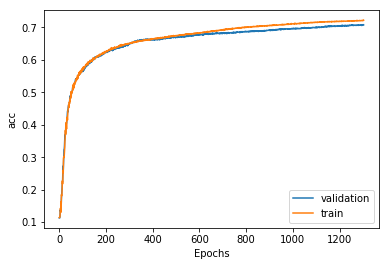

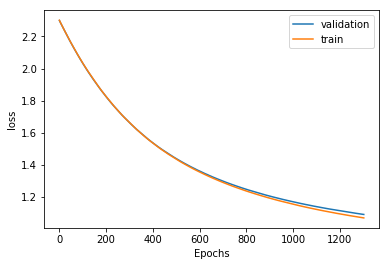

----------  DATASET MRB  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/50000
9600/9600 [==============================] - 0s 25us/step - loss: 2.3010 - acc: 0.1178 - val_loss: 2.2994 - val_acc: 0.1021
Epoch 2/50000
9600/9600 [=============================

9600/9600 [==============================] - 0s 22us/step - loss: 2.1549 - acc: 0.5685 - val_loss: 2.1598 - val_acc: 0.5779
Epoch 54/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1520 - acc: 0.6025 - val_loss: 2.1570 - val_acc: 0.5763
Epoch 55/50000
9600/9600 [==============================] - 0s 17us/step - loss: 2.1493 - acc: 0.6014 - val_loss: 2.1544 - val_acc: 0.5742
Epoch 56/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1467 - acc: 0.5930 - val_loss: 2.1518 - val_acc: 0.5767
Epoch 57/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1440 - acc: 0.5974 - val_loss: 2.1494 - val_acc: 0.5754
Epoch 58/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1414 - acc: 0.5911 - val_loss: 2.1467 - val_acc: 0.5937
Epoch 59/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1387 - acc: 0.6089 - val_loss: 2.1442 - val_acc: 0.5863
Epoch 60/50000
9600/9600 [================

Epoch 112/50000
9600/9600 [==============================] - 0s 15us/step - loss: 2.0026 - acc: 0.6866 - val_loss: 2.0139 - val_acc: 0.6567
Epoch 113/50000
9600/9600 [==============================] - 0s 17us/step - loss: 2.0001 - acc: 0.6828 - val_loss: 2.0116 - val_acc: 0.6529
Epoch 114/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.9977 - acc: 0.6920 - val_loss: 2.0091 - val_acc: 0.6617
Epoch 115/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.9952 - acc: 0.6840 - val_loss: 2.0068 - val_acc: 0.6575
Epoch 116/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.9928 - acc: 0.6894 - val_loss: 2.0045 - val_acc: 0.6558
Epoch 117/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9904 - acc: 0.6903 - val_loss: 2.0022 - val_acc: 0.6613
Epoch 118/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.9879 - acc: 0.6896 - val_loss: 1.9998 - val_acc: 0.6571
Epoch 119/50000
9600

9600/9600 [==============================] - 0s 16us/step - loss: 1.8664 - acc: 0.7170 - val_loss: 1.8834 - val_acc: 0.6804
Epoch 171/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.8641 - acc: 0.7167 - val_loss: 1.8812 - val_acc: 0.6787
Epoch 172/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.8619 - acc: 0.7129 - val_loss: 1.8790 - val_acc: 0.6825
Epoch 173/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.8597 - acc: 0.7181 - val_loss: 1.8768 - val_acc: 0.6825
Epoch 174/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.8574 - acc: 0.7164 - val_loss: 1.8748 - val_acc: 0.6858
Epoch 175/50000
9600/9600 [==============================] - 0s 21us/step - loss: 1.8551 - acc: 0.7198 - val_loss: 1.8726 - val_acc: 0.6837
Epoch 176/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.8530 - acc: 0.7204 - val_loss: 1.8705 - val_acc: 0.6837
Epoch 177/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.7434 - acc: 0.7389 - val_loss: 1.7658 - val_acc: 0.7008
Epoch 229/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7414 - acc: 0.7353 - val_loss: 1.7638 - val_acc: 0.7008
Epoch 230/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7393 - acc: 0.7343 - val_loss: 1.7619 - val_acc: 0.6992
Epoch 231/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7374 - acc: 0.7368 - val_loss: 1.7599 - val_acc: 0.7042
Epoch 232/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7353 - acc: 0.7359 - val_loss: 1.7580 - val_acc: 0.7000
Epoch 233/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7333 - acc: 0.7392 - val_loss: 1.7560 - val_acc: 0.7012
Epoch 234/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.7313 - acc: 0.7351 - val_loss: 1.7543 - val_acc: 0.6987
Epoch 235/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.6326 - acc: 0.7461 - val_loss: 1.6599 - val_acc: 0.7117
Epoch 287/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6308 - acc: 0.7478 - val_loss: 1.6582 - val_acc: 0.7117
Epoch 288/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6290 - acc: 0.7510 - val_loss: 1.6564 - val_acc: 0.7138
Epoch 289/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6272 - acc: 0.7482 - val_loss: 1.6548 - val_acc: 0.7117
Epoch 290/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6254 - acc: 0.7500 - val_loss: 1.6531 - val_acc: 0.7133
Epoch 291/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6236 - acc: 0.7483 - val_loss: 1.6514 - val_acc: 0.7121
Epoch 292/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6219 - acc: 0.7522 - val_loss: 1.6496 - val_acc: 0.7138
Epoch 293/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.5336 - acc: 0.7575 - val_loss: 1.5654 - val_acc: 0.7217
Epoch 345/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5319 - acc: 0.7554 - val_loss: 1.5640 - val_acc: 0.7221
Epoch 346/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5303 - acc: 0.7581 - val_loss: 1.5624 - val_acc: 0.7246
Epoch 347/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5286 - acc: 0.7579 - val_loss: 1.5609 - val_acc: 0.7246
Epoch 348/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5270 - acc: 0.7566 - val_loss: 1.5593 - val_acc: 0.7237
Epoch 349/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5255 - acc: 0.7566 - val_loss: 1.5578 - val_acc: 0.7246
Epoch 350/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5238 - acc: 0.7583 - val_loss: 1.5563 - val_acc: 0.7250
Epoch 351/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 22us/step - loss: 1.4450 - acc: 0.7648 - val_loss: 1.4813 - val_acc: 0.7329
Epoch 403/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.4436 - acc: 0.7665 - val_loss: 1.4799 - val_acc: 0.7325
Epoch 404/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.4421 - acc: 0.7648 - val_loss: 1.4784 - val_acc: 0.7329
Epoch 405/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.4407 - acc: 0.7662 - val_loss: 1.4771 - val_acc: 0.7333
Epoch 406/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4392 - acc: 0.7676 - val_loss: 1.4758 - val_acc: 0.7329
Epoch 407/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.4378 - acc: 0.7659 - val_loss: 1.4743 - val_acc: 0.7325
Epoch 408/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.4364 - acc: 0.7674 - val_loss: 1.4730 - val_acc: 0.7338
Epoch 409/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.3661 - acc: 0.7749 - val_loss: 1.4063 - val_acc: 0.7383
Epoch 461/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.3648 - acc: 0.7757 - val_loss: 1.4051 - val_acc: 0.7392
Epoch 462/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3635 - acc: 0.7731 - val_loss: 1.4040 - val_acc: 0.7379
Epoch 463/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3623 - acc: 0.7772 - val_loss: 1.4028 - val_acc: 0.7400
Epoch 464/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3610 - acc: 0.7721 - val_loss: 1.4016 - val_acc: 0.7375
Epoch 465/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.3597 - acc: 0.7746 - val_loss: 1.4003 - val_acc: 0.7383
Epoch 466/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.3585 - acc: 0.7765 - val_loss: 1.3990 - val_acc: 0.7396
Epoch 467/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.2958 - acc: 0.7815 - val_loss: 1.3399 - val_acc: 0.7450
Epoch 519/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.2947 - acc: 0.7829 - val_loss: 1.3387 - val_acc: 0.7433
Epoch 520/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.2935 - acc: 0.7808 - val_loss: 1.3377 - val_acc: 0.7429
Epoch 521/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.2924 - acc: 0.7790 - val_loss: 1.3366 - val_acc: 0.7425
Epoch 522/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2912 - acc: 0.7807 - val_loss: 1.3355 - val_acc: 0.7446
Epoch 523/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2901 - acc: 0.7812 - val_loss: 1.3343 - val_acc: 0.7429
Epoch 524/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.2890 - acc: 0.7812 - val_loss: 1.3334 - val_acc: 0.7446
Epoch 525/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 20us/step - loss: 1.2332 - acc: 0.7853 - val_loss: 1.2808 - val_acc: 0.7488
Epoch 577/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.2323 - acc: 0.7867 - val_loss: 1.2798 - val_acc: 0.7488
Epoch 578/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.2312 - acc: 0.7864 - val_loss: 1.2790 - val_acc: 0.7500
Epoch 579/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.2302 - acc: 0.7865 - val_loss: 1.2780 - val_acc: 0.7492
Epoch 580/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.2292 - acc: 0.7858 - val_loss: 1.2771 - val_acc: 0.7492
Epoch 581/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2282 - acc: 0.7868 - val_loss: 1.2759 - val_acc: 0.7492
Epoch 582/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.2272 - acc: 0.7867 - val_loss: 1.2751 - val_acc: 0.7508
Epoch 583/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.1773 - acc: 0.7894 - val_loss: 1.2282 - val_acc: 0.7542
Epoch 635/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.1764 - acc: 0.7897 - val_loss: 1.2273 - val_acc: 0.7550
Epoch 636/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1755 - acc: 0.7909 - val_loss: 1.2264 - val_acc: 0.7529
Epoch 637/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1746 - acc: 0.7913 - val_loss: 1.2256 - val_acc: 0.7550
Epoch 638/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1736 - acc: 0.7931 - val_loss: 1.2247 - val_acc: 0.7533
Epoch 639/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1728 - acc: 0.7902 - val_loss: 1.2238 - val_acc: 0.7546
Epoch 640/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1719 - acc: 0.7915 - val_loss: 1.2231 - val_acc: 0.7542
Epoch 641/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.1273 - acc: 0.7963 - val_loss: 1.1812 - val_acc: 0.7596
Epoch 693/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.1265 - acc: 0.7955 - val_loss: 1.1805 - val_acc: 0.7587
Epoch 694/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.1256 - acc: 0.7974 - val_loss: 1.1798 - val_acc: 0.7600
Epoch 695/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.1248 - acc: 0.7966 - val_loss: 1.1790 - val_acc: 0.7596
Epoch 696/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.1239 - acc: 0.7964 - val_loss: 1.1782 - val_acc: 0.7579
Epoch 697/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1232 - acc: 0.7964 - val_loss: 1.1775 - val_acc: 0.7587
Epoch 698/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.1224 - acc: 0.7958 - val_loss: 1.1768 - val_acc: 0.7587
Epoch 699/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 15us/step - loss: 1.0822 - acc: 0.7998 - val_loss: 1.1393 - val_acc: 0.7617
Epoch 751/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.0815 - acc: 0.8004 - val_loss: 1.1386 - val_acc: 0.7621
Epoch 752/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.0807 - acc: 0.8007 - val_loss: 1.1378 - val_acc: 0.7633
Epoch 753/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.0800 - acc: 0.8004 - val_loss: 1.1372 - val_acc: 0.7613
Epoch 754/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.0793 - acc: 0.7994 - val_loss: 1.1366 - val_acc: 0.7638
Epoch 755/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.0785 - acc: 0.8000 - val_loss: 1.1358 - val_acc: 0.7638
Epoch 756/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0779 - acc: 0.8003 - val_loss: 1.1352 - val_acc: 0.7642
Epoch 757/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 19us/step - loss: 1.0419 - acc: 0.8032 - val_loss: 1.1018 - val_acc: 0.7658
Epoch 809/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0413 - acc: 0.8026 - val_loss: 1.1012 - val_acc: 0.7667
Epoch 810/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.0406 - acc: 0.8027 - val_loss: 1.1006 - val_acc: 0.7654
Epoch 811/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.0399 - acc: 0.8030 - val_loss: 1.1000 - val_acc: 0.7658
Epoch 812/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.0393 - acc: 0.8031 - val_loss: 1.0994 - val_acc: 0.7650
Epoch 813/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.0386 - acc: 0.8027 - val_loss: 1.0988 - val_acc: 0.7667
Epoch 814/50000
9600/9600 [==============================] - 0s 21us/step - loss: 1.0380 - acc: 0.8035 - val_loss: 1.0981 - val_acc: 0.7658
Epoch 815/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 23us/step - loss: 1.0056 - acc: 0.8058 - val_loss: 1.0682 - val_acc: 0.7658
Epoch 867/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.0050 - acc: 0.8055 - val_loss: 1.0677 - val_acc: 0.7662
Epoch 868/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.0043 - acc: 0.8055 - val_loss: 1.0671 - val_acc: 0.7658
Epoch 869/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.0038 - acc: 0.8066 - val_loss: 1.0665 - val_acc: 0.7662
Epoch 870/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.0032 - acc: 0.8064 - val_loss: 1.0660 - val_acc: 0.7658
Epoch 871/50000
9600/9600 [==============================] - 0s 21us/step - loss: 1.0026 - acc: 0.8055 - val_loss: 1.0655 - val_acc: 0.7662
Epoch 872/50000
9600/9600 [==============================] - 0s 21us/step - loss: 1.0020 - acc: 0.8064 - val_loss: 1.0649 - val_acc: 0.7662
Epoch 873/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 0.9726 - acc: 0.8085 - val_loss: 1.0379 - val_acc: 0.7687
Epoch 925/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9720 - acc: 0.8084 - val_loss: 1.0374 - val_acc: 0.7688
Epoch 926/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9715 - acc: 0.8088 - val_loss: 1.0368 - val_acc: 0.7683
Epoch 927/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.9710 - acc: 0.8093 - val_loss: 1.0364 - val_acc: 0.7675
Epoch 928/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.9705 - acc: 0.8096 - val_loss: 1.0359 - val_acc: 0.7675
Epoch 929/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9699 - acc: 0.8092 - val_loss: 1.0354 - val_acc: 0.7683
Epoch 930/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9694 - acc: 0.8091 - val_loss: 1.0348 - val_acc: 0.7683
Epoch 931/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 19us/step - loss: 0.9427 - acc: 0.8119 - val_loss: 1.0105 - val_acc: 0.7696
Epoch 983/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.9422 - acc: 0.8123 - val_loss: 1.0100 - val_acc: 0.7704
Epoch 984/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.9417 - acc: 0.8120 - val_loss: 1.0094 - val_acc: 0.7704
Epoch 985/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9412 - acc: 0.8121 - val_loss: 1.0091 - val_acc: 0.7700
Epoch 986/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9407 - acc: 0.8125 - val_loss: 1.0086 - val_acc: 0.7704
Epoch 987/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9402 - acc: 0.8122 - val_loss: 1.0081 - val_acc: 0.7704
Epoch 988/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9397 - acc: 0.8121 - val_loss: 1.0078 - val_acc: 0.7704
Epoch 989/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 0.9151 - acc: 0.8139 - val_loss: 0.9853 - val_acc: 0.7721
Epoch 1041/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9146 - acc: 0.8143 - val_loss: 0.9849 - val_acc: 0.7733
Epoch 1042/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9142 - acc: 0.8141 - val_loss: 0.9844 - val_acc: 0.7733
Epoch 1043/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9137 - acc: 0.8139 - val_loss: 0.9841 - val_acc: 0.7750
Epoch 1044/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.9133 - acc: 0.8139 - val_loss: 0.9837 - val_acc: 0.7737
Epoch 1045/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.9129 - acc: 0.8139 - val_loss: 0.9833 - val_acc: 0.7738
Epoch 1046/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.9124 - acc: 0.8144 - val_loss: 0.9829 - val_acc: 0.7721
Epoch 1047/50000
9600/9600 [==

9600/9600 [==============================] - 0s 18us/step - loss: 0.8900 - acc: 0.8153 - val_loss: 0.9626 - val_acc: 0.7762
Epoch 1099/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.8895 - acc: 0.8160 - val_loss: 0.9623 - val_acc: 0.7762
Epoch 1100/50000
9600/9600 [==============================] - 0s 23us/step - loss: 0.8891 - acc: 0.8166 - val_loss: 0.9619 - val_acc: 0.7746
Epoch 1101/50000
9600/9600 [==============================] - 0s 20us/step - loss: 0.8888 - acc: 0.8161 - val_loss: 0.9615 - val_acc: 0.7775
Epoch 1102/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.8883 - acc: 0.8156 - val_loss: 0.9612 - val_acc: 0.7775
Epoch 1103/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.8879 - acc: 0.8156 - val_loss: 0.9607 - val_acc: 0.7775
Epoch 1104/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.8876 - acc: 0.8165 - val_loss: 0.9603 - val_acc: 0.7771
Epoch 1105/50000
9600/9600 [==

9600/9600 [==============================] - 0s 18us/step - loss: 0.8669 - acc: 0.8186 - val_loss: 0.9418 - val_acc: 0.7783
Epoch 1157/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.8665 - acc: 0.8180 - val_loss: 0.9415 - val_acc: 0.7788
Epoch 1158/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.8661 - acc: 0.8181 - val_loss: 0.9412 - val_acc: 0.7796
Epoch 1159/50000
9600/9600 [==============================] - 0s 23us/step - loss: 0.8658 - acc: 0.8183 - val_loss: 0.9409 - val_acc: 0.7808
Epoch 1160/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.8654 - acc: 0.8179 - val_loss: 0.9405 - val_acc: 0.7796
Epoch 1161/50000
9600/9600 [==============================] - 0s 22us/step - loss: 0.8650 - acc: 0.8180 - val_loss: 0.9402 - val_acc: 0.7792
Epoch 1162/50000
9600/9600 [==============================] - 0s 24us/step - loss: 0.8646 - acc: 0.8190 - val_loss: 0.9398 - val_acc: 0.7808
Epoch 1163/50000
9600/9600 [==

9600/9600 [==============================] - 0s 15us/step - loss: 0.8456 - acc: 0.8199 - val_loss: 0.9229 - val_acc: 0.7825
Epoch 1215/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.8452 - acc: 0.8194 - val_loss: 0.9225 - val_acc: 0.7825
Epoch 1216/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.8449 - acc: 0.8198 - val_loss: 0.9222 - val_acc: 0.7821
Epoch 1217/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.8446 - acc: 0.8201 - val_loss: 0.9219 - val_acc: 0.7817
Epoch 1218/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8442 - acc: 0.8199 - val_loss: 0.9216 - val_acc: 0.7825
Epoch 1219/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.8439 - acc: 0.8198 - val_loss: 0.9213 - val_acc: 0.7825
Epoch 1220/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.8436 - acc: 0.8200 - val_loss: 0.9210 - val_acc: 0.7804
Epoch 1221/50000
9600/9600 [==

9600/9600 [==============================] - 0s 15us/step - loss: 0.8259 - acc: 0.8220 - val_loss: 0.9054 - val_acc: 0.7837
Epoch 1273/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8256 - acc: 0.8221 - val_loss: 0.9051 - val_acc: 0.7850
Epoch 1274/50000
9600/9600 [==============================] - 0s 16us/step - loss: 0.8252 - acc: 0.8218 - val_loss: 0.9049 - val_acc: 0.7850
Epoch 1275/50000
9600/9600 [==============================] - 0s 17us/step - loss: 0.8249 - acc: 0.8220 - val_loss: 0.9045 - val_acc: 0.7850
Epoch 1276/50000
9600/9600 [==============================] - 0s 20us/step - loss: 0.8245 - acc: 0.8224 - val_loss: 0.9042 - val_acc: 0.7837
Epoch 1277/50000
9600/9600 [==============================] - 0s 20us/step - loss: 0.8243 - acc: 0.8223 - val_loss: 0.9039 - val_acc: 0.7850
Epoch 1278/50000
9600/9600 [==============================] - 0s 15us/step - loss: 0.8239 - acc: 0.8222 - val_loss: 0.9036 - val_acc: 0.7833
Epoch 1279/50000
9600/9600 [==

9600/9600 [==============================] - 0s 17us/step - loss: 0.8077 - acc: 0.8243 - val_loss: 0.8893 - val_acc: 0.7842
Epoch 1331/50000
9600/9600 [==============================] - 0s 20us/step - loss: 0.8074 - acc: 0.8239 - val_loss: 0.8891 - val_acc: 0.7846
Epoch 1332/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.8070 - acc: 0.8239 - val_loss: 0.8889 - val_acc: 0.7850
Epoch 1333/50000
9600/9600 [==============================] - 0s 19us/step - loss: 0.8068 - acc: 0.8240 - val_loss: 0.8886 - val_acc: 0.7850
Epoch 1334/50000
9600/9600 [==============================] - 0s 18us/step - loss: 0.8065 - acc: 0.8241 - val_loss: 0.8883 - val_acc: 0.7850
Val loss: 0.9019,Val acc: 0.7854


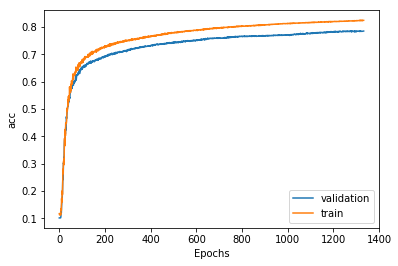

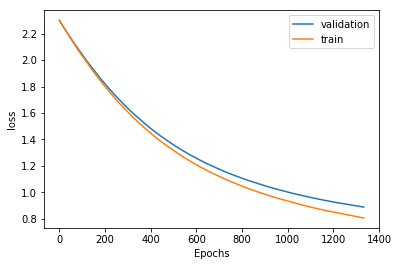

----------  DATASET MRD  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/50000
9600/9600 [==============================] - 0s 23us/step - loss: 2.2999 - acc: 0.1506 - val_loss: 2.2966 - val_acc: 0.2154
Epoch 2/50000
9600/9600 [=============================

9600/9600 [==============================] - 0s 16us/step - loss: 2.0665 - acc: 0.4083 - val_loss: 2.0666 - val_acc: 0.4062
Epoch 54/50000
9600/9600 [==============================] - 0s 15us/step - loss: 2.0628 - acc: 0.4131 - val_loss: 2.0630 - val_acc: 0.4087
Epoch 55/50000
9600/9600 [==============================] - 0s 17us/step - loss: 2.0591 - acc: 0.4095 - val_loss: 2.0595 - val_acc: 0.4067
Epoch 56/50000
9600/9600 [==============================] - 0s 23us/step - loss: 2.0555 - acc: 0.4118 - val_loss: 2.0558 - val_acc: 0.4100
Epoch 57/50000
9600/9600 [==============================] - 0s 19us/step - loss: 2.0519 - acc: 0.4127 - val_loss: 2.0523 - val_acc: 0.4096
Epoch 58/50000
9600/9600 [==============================] - 0s 18us/step - loss: 2.0483 - acc: 0.4157 - val_loss: 2.0489 - val_acc: 0.4104
Epoch 59/50000
9600/9600 [==============================] - 0s 17us/step - loss: 2.0448 - acc: 0.4164 - val_loss: 2.0453 - val_acc: 0.4104
Epoch 60/50000
9600/9600 [================

Epoch 112/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.8861 - acc: 0.4540 - val_loss: 1.8897 - val_acc: 0.4442
Epoch 113/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.8836 - acc: 0.4550 - val_loss: 1.8873 - val_acc: 0.4442
Epoch 114/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.8812 - acc: 0.4553 - val_loss: 1.8848 - val_acc: 0.4450
Epoch 115/50000
9600/9600 [==============================] - 0s 26us/step - loss: 1.8786 - acc: 0.4561 - val_loss: 1.8824 - val_acc: 0.4462
Epoch 116/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.8762 - acc: 0.4564 - val_loss: 1.8800 - val_acc: 0.4467
Epoch 117/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.8737 - acc: 0.4562 - val_loss: 1.8777 - val_acc: 0.4471
Epoch 118/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.8713 - acc: 0.4561 - val_loss: 1.8752 - val_acc: 0.4471
Epoch 119/50000
9600

9600/9600 [==============================] - 0s 15us/step - loss: 1.7627 - acc: 0.4789 - val_loss: 1.7694 - val_acc: 0.4683
Epoch 171/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7609 - acc: 0.4786 - val_loss: 1.7677 - val_acc: 0.4688
Epoch 172/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7592 - acc: 0.4794 - val_loss: 1.7660 - val_acc: 0.4688
Epoch 173/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.7574 - acc: 0.4790 - val_loss: 1.7642 - val_acc: 0.4700
Epoch 174/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.7556 - acc: 0.4786 - val_loss: 1.7626 - val_acc: 0.4692
Epoch 175/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7539 - acc: 0.4801 - val_loss: 1.7609 - val_acc: 0.4708
Epoch 176/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.7521 - acc: 0.4807 - val_loss: 1.7592 - val_acc: 0.4696
Epoch 177/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 29us/step - loss: 1.6735 - acc: 0.4934 - val_loss: 1.6832 - val_acc: 0.4792
Epoch 229/50000
9600/9600 [==============================] - 0s 25us/step - loss: 1.6722 - acc: 0.4947 - val_loss: 1.6819 - val_acc: 0.4788
Epoch 230/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.6709 - acc: 0.4939 - val_loss: 1.6807 - val_acc: 0.4804
Epoch 231/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.6696 - acc: 0.4948 - val_loss: 1.6793 - val_acc: 0.4808
Epoch 232/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6683 - acc: 0.4941 - val_loss: 1.6782 - val_acc: 0.4804
Epoch 233/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.6670 - acc: 0.4966 - val_loss: 1.6770 - val_acc: 0.4792
Epoch 234/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.6657 - acc: 0.4955 - val_loss: 1.6757 - val_acc: 0.4821
Epoch 235/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.6068 - acc: 0.5045 - val_loss: 1.6191 - val_acc: 0.4888
Epoch 287/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.6058 - acc: 0.5052 - val_loss: 1.6181 - val_acc: 0.4904
Epoch 288/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.6048 - acc: 0.5055 - val_loss: 1.6172 - val_acc: 0.4879
Epoch 289/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.6038 - acc: 0.5058 - val_loss: 1.6163 - val_acc: 0.4900
Epoch 290/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6028 - acc: 0.5058 - val_loss: 1.6154 - val_acc: 0.4888
Epoch 291/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.6018 - acc: 0.5060 - val_loss: 1.6144 - val_acc: 0.4896
Epoch 292/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.6008 - acc: 0.5059 - val_loss: 1.6135 - val_acc: 0.4892
Epoch 293/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.5554 - acc: 0.5147 - val_loss: 1.5703 - val_acc: 0.4962
Epoch 345/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5546 - acc: 0.5140 - val_loss: 1.5695 - val_acc: 0.4967
Epoch 346/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5539 - acc: 0.5155 - val_loss: 1.5687 - val_acc: 0.4967
Epoch 347/50000
9600/9600 [==============================] - 0s 26us/step - loss: 1.5531 - acc: 0.5145 - val_loss: 1.5680 - val_acc: 0.4975
Epoch 348/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.5523 - acc: 0.5150 - val_loss: 1.5673 - val_acc: 0.4971
Epoch 349/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.5515 - acc: 0.5144 - val_loss: 1.5665 - val_acc: 0.4958
Epoch 350/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.5507 - acc: 0.5149 - val_loss: 1.5658 - val_acc: 0.4958
Epoch 351/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 15us/step - loss: 1.5147 - acc: 0.5205 - val_loss: 1.5318 - val_acc: 0.5029
Epoch 403/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.5141 - acc: 0.5200 - val_loss: 1.5312 - val_acc: 0.5029
Epoch 404/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5135 - acc: 0.5190 - val_loss: 1.5306 - val_acc: 0.5025
Epoch 405/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5129 - acc: 0.5196 - val_loss: 1.5301 - val_acc: 0.5021
Epoch 406/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5123 - acc: 0.5198 - val_loss: 1.5295 - val_acc: 0.5021
Epoch 407/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5116 - acc: 0.5198 - val_loss: 1.5289 - val_acc: 0.5025
Epoch 408/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.5110 - acc: 0.5204 - val_loss: 1.5283 - val_acc: 0.5025
Epoch 409/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 15us/step - loss: 1.4817 - acc: 0.5254 - val_loss: 1.5010 - val_acc: 0.5079
Epoch 461/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4812 - acc: 0.5257 - val_loss: 1.5005 - val_acc: 0.5083
Epoch 462/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4807 - acc: 0.5256 - val_loss: 1.5000 - val_acc: 0.5083
Epoch 463/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4802 - acc: 0.5257 - val_loss: 1.4995 - val_acc: 0.5088
Epoch 464/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4797 - acc: 0.5258 - val_loss: 1.4991 - val_acc: 0.5092
Epoch 465/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4791 - acc: 0.5260 - val_loss: 1.4987 - val_acc: 0.5096
Epoch 466/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.4787 - acc: 0.5264 - val_loss: 1.4980 - val_acc: 0.5096
Epoch 467/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 18us/step - loss: 1.4545 - acc: 0.5292 - val_loss: 1.4756 - val_acc: 0.5154
Epoch 519/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.4540 - acc: 0.5290 - val_loss: 1.4754 - val_acc: 0.5158
Epoch 520/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.4536 - acc: 0.5291 - val_loss: 1.4750 - val_acc: 0.5162
Epoch 521/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.4532 - acc: 0.5293 - val_loss: 1.4746 - val_acc: 0.5171
Epoch 522/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.4528 - acc: 0.5296 - val_loss: 1.4742 - val_acc: 0.5171
Epoch 523/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.4523 - acc: 0.5297 - val_loss: 1.4739 - val_acc: 0.5175
Epoch 524/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.4519 - acc: 0.5295 - val_loss: 1.4734 - val_acc: 0.5171
Epoch 525/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.4316 - acc: 0.5326 - val_loss: 1.4549 - val_acc: 0.5188
Epoch 577/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4313 - acc: 0.5331 - val_loss: 1.4545 - val_acc: 0.5188
Epoch 578/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4309 - acc: 0.5321 - val_loss: 1.4542 - val_acc: 0.5192
Epoch 579/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4305 - acc: 0.5330 - val_loss: 1.4539 - val_acc: 0.5192
Epoch 580/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4302 - acc: 0.5331 - val_loss: 1.4535 - val_acc: 0.5188
Epoch 581/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4298 - acc: 0.5335 - val_loss: 1.4533 - val_acc: 0.5188
Epoch 582/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4295 - acc: 0.5330 - val_loss: 1.4529 - val_acc: 0.5192
Epoch 583/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.4121 - acc: 0.5367 - val_loss: 1.4373 - val_acc: 0.5217
Epoch 635/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4118 - acc: 0.5369 - val_loss: 1.4370 - val_acc: 0.5229
Epoch 636/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4115 - acc: 0.5364 - val_loss: 1.4368 - val_acc: 0.5221
Epoch 637/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4112 - acc: 0.5367 - val_loss: 1.4364 - val_acc: 0.5221
Epoch 638/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4109 - acc: 0.5363 - val_loss: 1.4362 - val_acc: 0.5229
Epoch 639/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.4106 - acc: 0.5370 - val_loss: 1.4359 - val_acc: 0.5233
Epoch 640/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.4103 - acc: 0.5374 - val_loss: 1.4357 - val_acc: 0.5233
Epoch 641/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 1.3954 - acc: 0.5390 - val_loss: 1.4223 - val_acc: 0.5283
Epoch 693/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3951 - acc: 0.5395 - val_loss: 1.4221 - val_acc: 0.5279
Epoch 694/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.3948 - acc: 0.5392 - val_loss: 1.4219 - val_acc: 0.5283
Epoch 695/50000
9600/9600 [==============================] - 0s 22us/step - loss: 1.3946 - acc: 0.5396 - val_loss: 1.4217 - val_acc: 0.5271
Epoch 696/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3943 - acc: 0.5401 - val_loss: 1.4214 - val_acc: 0.5267
Epoch 697/50000
9600/9600 [==============================] - 0s 15us/step - loss: 1.3940 - acc: 0.5397 - val_loss: 1.4213 - val_acc: 0.5279
Epoch 698/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3938 - acc: 0.5399 - val_loss: 1.4209 - val_acc: 0.5287
Epoch 699/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.3808 - acc: 0.5432 - val_loss: 1.4096 - val_acc: 0.5317
Epoch 751/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3806 - acc: 0.5438 - val_loss: 1.4094 - val_acc: 0.5317
Epoch 752/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.3804 - acc: 0.5431 - val_loss: 1.4092 - val_acc: 0.5313
Epoch 753/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3801 - acc: 0.5441 - val_loss: 1.4090 - val_acc: 0.5321
Epoch 754/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.3799 - acc: 0.5434 - val_loss: 1.4088 - val_acc: 0.5317
Epoch 755/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3797 - acc: 0.5442 - val_loss: 1.4086 - val_acc: 0.5325
Epoch 756/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3794 - acc: 0.5436 - val_loss: 1.4084 - val_acc: 0.5317
Epoch 757/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 19us/step - loss: 1.3680 - acc: 0.5457 - val_loss: 1.3986 - val_acc: 0.5333
Epoch 809/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.3678 - acc: 0.5459 - val_loss: 1.3984 - val_acc: 0.5329
Epoch 810/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.3676 - acc: 0.5454 - val_loss: 1.3983 - val_acc: 0.5329
Epoch 811/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.3674 - acc: 0.5458 - val_loss: 1.3981 - val_acc: 0.5342
Epoch 812/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3672 - acc: 0.5473 - val_loss: 1.3979 - val_acc: 0.5338
Epoch 813/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3670 - acc: 0.5461 - val_loss: 1.3977 - val_acc: 0.5317
Epoch 814/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3668 - acc: 0.5466 - val_loss: 1.3976 - val_acc: 0.5321
Epoch 815/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 29us/step - loss: 1.3567 - acc: 0.5483 - val_loss: 1.3891 - val_acc: 0.5354
Epoch 867/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.3565 - acc: 0.5479 - val_loss: 1.3889 - val_acc: 0.5354
Epoch 868/50000
9600/9600 [==============================] - 0s 23us/step - loss: 1.3563 - acc: 0.5476 - val_loss: 1.3888 - val_acc: 0.5350
Epoch 869/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.3562 - acc: 0.5477 - val_loss: 1.3886 - val_acc: 0.5354
Epoch 870/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.3560 - acc: 0.5482 - val_loss: 1.3884 - val_acc: 0.5350
Epoch 871/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.3558 - acc: 0.5487 - val_loss: 1.3883 - val_acc: 0.5350
Epoch 872/50000
9600/9600 [==============================] - 0s 19us/step - loss: 1.3556 - acc: 0.5486 - val_loss: 1.3881 - val_acc: 0.5342
Epoch 873/50000
9600/9600 [=========

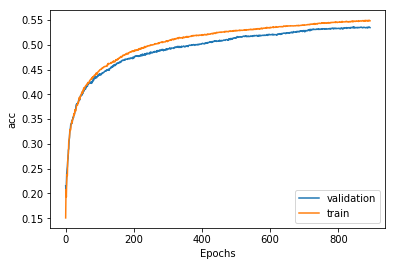

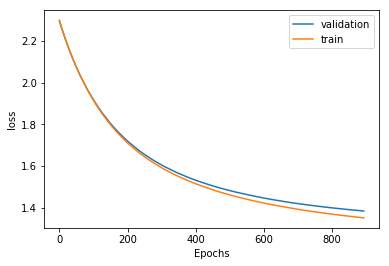

----------  DATASET MRDBI  ----------
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples

	Training model:
logreg


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 9600 samples, validate on 2400 samples
Epoch 1/50000
9600/9600 [==============================] - 0s 24us/step - loss: 2.3016 - acc: 0.1136 - val_loss: 2.3016 - val_acc: 0.1154
Epoch 2/50000
9600/9600 [===========================

9600/9600 [==============================] - 0s 15us/step - loss: 2.2515 - acc: 0.2076 - val_loss: 2.2552 - val_acc: 0.2058
Epoch 54/50000
9600/9600 [==============================] - 0s 15us/step - loss: 2.2507 - acc: 0.2017 - val_loss: 2.2541 - val_acc: 0.2071
Epoch 55/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.2497 - acc: 0.2047 - val_loss: 2.2535 - val_acc: 0.2062
Epoch 56/50000
9600/9600 [==============================] - 0s 15us/step - loss: 2.2489 - acc: 0.2100 - val_loss: 2.2527 - val_acc: 0.2125
Epoch 57/50000
9600/9600 [==============================] - 0s 15us/step - loss: 2.2481 - acc: 0.2097 - val_loss: 2.2518 - val_acc: 0.2075
Epoch 58/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.2472 - acc: 0.2109 - val_loss: 2.2509 - val_acc: 0.2150
Epoch 59/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.2463 - acc: 0.2136 - val_loss: 2.2501 - val_acc: 0.2133
Epoch 60/50000
9600/9600 [================

Epoch 112/50000
9600/9600 [==============================] - 0s 23us/step - loss: 2.2037 - acc: 0.2660 - val_loss: 2.2087 - val_acc: 0.2696
Epoch 113/50000
9600/9600 [==============================] - 0s 21us/step - loss: 2.2030 - acc: 0.2645 - val_loss: 2.2078 - val_acc: 0.2621
Epoch 114/50000
9600/9600 [==============================] - 0s 17us/step - loss: 2.2022 - acc: 0.2716 - val_loss: 2.2071 - val_acc: 0.2650
Epoch 115/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.2015 - acc: 0.2722 - val_loss: 2.2063 - val_acc: 0.2667
Epoch 116/50000
9600/9600 [==============================] - 0s 19us/step - loss: 2.2007 - acc: 0.2704 - val_loss: 2.2058 - val_acc: 0.2696
Epoch 117/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.2000 - acc: 0.2714 - val_loss: 2.2052 - val_acc: 0.2683
Epoch 118/50000
9600/9600 [==============================] - 0s 15us/step - loss: 2.1993 - acc: 0.2677 - val_loss: 2.2042 - val_acc: 0.2683
Epoch 119/50000
9600

9600/9600 [==============================] - 0s 15us/step - loss: 2.1625 - acc: 0.2922 - val_loss: 2.1693 - val_acc: 0.2825
Epoch 171/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1619 - acc: 0.2979 - val_loss: 2.1685 - val_acc: 0.2858
Epoch 172/50000
9600/9600 [==============================] - 0s 19us/step - loss: 2.1612 - acc: 0.2923 - val_loss: 2.1679 - val_acc: 0.2833
Epoch 173/50000
9600/9600 [==============================] - 0s 18us/step - loss: 2.1606 - acc: 0.2942 - val_loss: 2.1671 - val_acc: 0.2821
Epoch 174/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1599 - acc: 0.2965 - val_loss: 2.1667 - val_acc: 0.2887
Epoch 175/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1592 - acc: 0.2943 - val_loss: 2.1660 - val_acc: 0.2825
Epoch 176/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1585 - acc: 0.2942 - val_loss: 2.1655 - val_acc: 0.2908
Epoch 177/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 18us/step - loss: 2.1261 - acc: 0.3081 - val_loss: 2.1348 - val_acc: 0.2917
Epoch 229/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1255 - acc: 0.3117 - val_loss: 2.1342 - val_acc: 0.2962
Epoch 230/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1249 - acc: 0.3136 - val_loss: 2.1336 - val_acc: 0.2950
Epoch 231/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.1243 - acc: 0.3117 - val_loss: 2.1331 - val_acc: 0.2958
Epoch 232/50000
9600/9600 [==============================] - 0s 17us/step - loss: 2.1238 - acc: 0.3091 - val_loss: 2.1324 - val_acc: 0.2929
Epoch 233/50000
9600/9600 [==============================] - 0s 20us/step - loss: 2.1231 - acc: 0.3107 - val_loss: 2.1318 - val_acc: 0.2975
Epoch 234/50000
9600/9600 [==============================] - 0s 19us/step - loss: 2.1226 - acc: 0.3141 - val_loss: 2.1316 - val_acc: 0.2958
Epoch 235/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 17us/step - loss: 2.0939 - acc: 0.3225 - val_loss: 2.1047 - val_acc: 0.3021
Epoch 287/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0935 - acc: 0.3230 - val_loss: 2.1042 - val_acc: 0.3029
Epoch 288/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0929 - acc: 0.3220 - val_loss: 2.1038 - val_acc: 0.3029
Epoch 289/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0925 - acc: 0.3217 - val_loss: 2.1035 - val_acc: 0.3042
Epoch 290/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0919 - acc: 0.3244 - val_loss: 2.1031 - val_acc: 0.3025
Epoch 291/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0914 - acc: 0.3232 - val_loss: 2.1025 - val_acc: 0.3050
Epoch 292/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0909 - acc: 0.3239 - val_loss: 2.1015 - val_acc: 0.3042
Epoch 293/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 2.0654 - acc: 0.3311 - val_loss: 2.0787 - val_acc: 0.3079
Epoch 345/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0650 - acc: 0.3305 - val_loss: 2.0783 - val_acc: 0.3062
Epoch 346/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0646 - acc: 0.3306 - val_loss: 2.0778 - val_acc: 0.3083
Epoch 347/50000
9600/9600 [==============================] - 0s 17us/step - loss: 2.0641 - acc: 0.3333 - val_loss: 2.0775 - val_acc: 0.3083
Epoch 348/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0636 - acc: 0.3328 - val_loss: 2.0769 - val_acc: 0.3083
Epoch 349/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0632 - acc: 0.3321 - val_loss: 2.0766 - val_acc: 0.3075
Epoch 350/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0627 - acc: 0.3326 - val_loss: 2.0762 - val_acc: 0.3083
Epoch 351/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 2.0401 - acc: 0.3416 - val_loss: 2.0556 - val_acc: 0.3167
Epoch 403/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0397 - acc: 0.3391 - val_loss: 2.0552 - val_acc: 0.3137
Epoch 404/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0393 - acc: 0.3373 - val_loss: 2.0550 - val_acc: 0.3154
Epoch 405/50000
9600/9600 [==============================] - 0s 18us/step - loss: 2.0389 - acc: 0.3408 - val_loss: 2.0547 - val_acc: 0.3150
Epoch 406/50000
9600/9600 [==============================] - 0s 18us/step - loss: 2.0384 - acc: 0.3412 - val_loss: 2.0543 - val_acc: 0.3137
Epoch 407/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0380 - acc: 0.3417 - val_loss: 2.0542 - val_acc: 0.3167
Epoch 408/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0377 - acc: 0.3425 - val_loss: 2.0537 - val_acc: 0.3150
Epoch 409/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 2.0172 - acc: 0.3468 - val_loss: 2.0354 - val_acc: 0.3208
Epoch 461/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0169 - acc: 0.3469 - val_loss: 2.0350 - val_acc: 0.3212
Epoch 462/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0165 - acc: 0.3435 - val_loss: 2.0348 - val_acc: 0.3229
Epoch 463/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0161 - acc: 0.3465 - val_loss: 2.0347 - val_acc: 0.3200
Epoch 464/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0158 - acc: 0.3460 - val_loss: 2.0343 - val_acc: 0.3196
Epoch 465/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0154 - acc: 0.3466 - val_loss: 2.0340 - val_acc: 0.3192
Epoch 466/50000
9600/9600 [==============================] - 0s 16us/step - loss: 2.0150 - acc: 0.3456 - val_loss: 2.0335 - val_acc: 0.3208
Epoch 467/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.9965 - acc: 0.3496 - val_loss: 2.0171 - val_acc: 0.3187
Epoch 519/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9962 - acc: 0.3525 - val_loss: 2.0170 - val_acc: 0.3188
Epoch 520/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9959 - acc: 0.3495 - val_loss: 2.0166 - val_acc: 0.3208
Epoch 521/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9955 - acc: 0.3501 - val_loss: 2.0162 - val_acc: 0.3217
Epoch 522/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9952 - acc: 0.3505 - val_loss: 2.0162 - val_acc: 0.3237
Epoch 523/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.9949 - acc: 0.3499 - val_loss: 2.0157 - val_acc: 0.3200
Epoch 524/50000
9600/9600 [==============================] - 0s 20us/step - loss: 1.9945 - acc: 0.3524 - val_loss: 2.0157 - val_acc: 0.3237
Epoch 525/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 16us/step - loss: 1.9778 - acc: 0.3532 - val_loss: 2.0011 - val_acc: 0.3258
Epoch 577/50000
9600/9600 [==============================] - 0s 18us/step - loss: 1.9775 - acc: 0.3521 - val_loss: 2.0010 - val_acc: 0.3242
Epoch 578/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.9772 - acc: 0.3555 - val_loss: 2.0006 - val_acc: 0.3246
Epoch 579/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9770 - acc: 0.3548 - val_loss: 2.0003 - val_acc: 0.3225
Epoch 580/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9766 - acc: 0.3540 - val_loss: 2.0002 - val_acc: 0.3250
Epoch 581/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9763 - acc: 0.3541 - val_loss: 1.9995 - val_acc: 0.3267
Epoch 582/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9760 - acc: 0.3548 - val_loss: 1.9994 - val_acc: 0.3254
Epoch 583/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 18us/step - loss: 1.9608 - acc: 0.3603 - val_loss: 1.9867 - val_acc: 0.3275
Epoch 635/50000
9600/9600 [==============================] - 0s 17us/step - loss: 1.9605 - acc: 0.3570 - val_loss: 1.9863 - val_acc: 0.3275
Epoch 636/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9602 - acc: 0.3572 - val_loss: 1.9862 - val_acc: 0.3283
Epoch 637/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9600 - acc: 0.3574 - val_loss: 1.9860 - val_acc: 0.3267
Epoch 638/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9596 - acc: 0.3593 - val_loss: 1.9857 - val_acc: 0.3283
Epoch 639/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9593 - acc: 0.3599 - val_loss: 1.9854 - val_acc: 0.3292
Epoch 640/50000
9600/9600 [==============================] - 0s 16us/step - loss: 1.9591 - acc: 0.3588 - val_loss: 1.9851 - val_acc: 0.3279
Epoch 641/50000
9600/9600 [=========

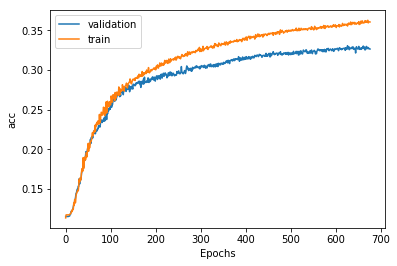

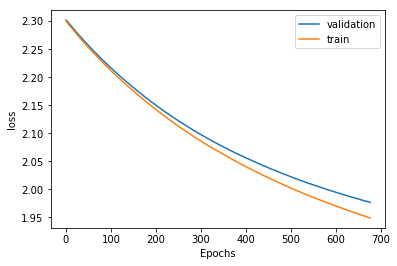


	Training model:
simplest
0 - U:830|A:prelu|D:0.654 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8310      
Total params: 660,690
Trainable params: 660,690
Non-trainable params: 0
______________

9600/9600 [==============================] - 0s 32us/step - loss: 1.7328 - acc: 0.3723 - val_loss: 1.7811 - val_acc: 0.3438
Epoch 52/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.7310 - acc: 0.3720 - val_loss: 1.7988 - val_acc: 0.3433
Epoch 53/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.7323 - acc: 0.3726 - val_loss: 1.7791 - val_acc: 0.3475
Epoch 54/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.7242 - acc: 0.3797 - val_loss: 1.7723 - val_acc: 0.3508
Epoch 55/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.7252 - acc: 0.3784 - val_loss: 1.7858 - val_acc: 0.3442
Epoch 56/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.7248 - acc: 0.3777 - val_loss: 1.7696 - val_acc: 0.3512
Epoch 57/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.7218 - acc: 0.3766 - val_loss: 1.7744 - val_acc: 0.3529
Epoch 58/50000
9600/9600 [================

Epoch 110/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.6353 - acc: 0.4130 - val_loss: 1.7481 - val_acc: 0.3683
Epoch 111/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.6276 - acc: 0.4200 - val_loss: 1.7483 - val_acc: 0.3633
Epoch 112/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.6307 - acc: 0.4159 - val_loss: 1.7462 - val_acc: 0.3671
Epoch 113/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.6332 - acc: 0.4146 - val_loss: 1.7551 - val_acc: 0.3558
Epoch 114/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.6251 - acc: 0.4206 - val_loss: 1.7503 - val_acc: 0.3538
Epoch 115/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.6267 - acc: 0.4148 - val_loss: 1.7467 - val_acc: 0.3633
Epoch 116/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.6196 - acc: 0.4191 - val_loss: 1.7553 - val_acc: 0.3654
Epoch 117/50000
9600

9600/9600 [==============================] - 0s 36us/step - loss: 1.5307 - acc: 0.4566 - val_loss: 1.7253 - val_acc: 0.3683
Epoch 169/50000
9600/9600 [==============================] - 0s 34us/step - loss: 1.5353 - acc: 0.4519 - val_loss: 1.7277 - val_acc: 0.3733
Epoch 170/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.5365 - acc: 0.4523 - val_loss: 1.7323 - val_acc: 0.3754
Epoch 171/50000
9600/9600 [==============================] - 0s 33us/step - loss: 1.5252 - acc: 0.4599 - val_loss: 1.7447 - val_acc: 0.3654
Epoch 172/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.5268 - acc: 0.4589 - val_loss: 1.7247 - val_acc: 0.3721
Epoch 173/50000
9600/9600 [==============================] - 0s 33us/step - loss: 1.5255 - acc: 0.4560 - val_loss: 1.7168 - val_acc: 0.3754
Epoch 174/50000
9600/9600 [==============================] - 0s 35us/step - loss: 1.5233 - acc: 0.4567 - val_loss: 1.7176 - val_acc: 0.3787
Epoch 175/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 28us/step - loss: 1.4438 - acc: 0.4955 - val_loss: 1.7108 - val_acc: 0.3904
Epoch 227/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4426 - acc: 0.4857 - val_loss: 1.7135 - val_acc: 0.3875
Epoch 228/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4452 - acc: 0.4907 - val_loss: 1.7089 - val_acc: 0.3921
Epoch 229/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4388 - acc: 0.4839 - val_loss: 1.7047 - val_acc: 0.3879
Epoch 230/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4273 - acc: 0.4936 - val_loss: 1.7190 - val_acc: 0.3838
Epoch 231/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4260 - acc: 0.4994 - val_loss: 1.7003 - val_acc: 0.3954
Epoch 232/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4293 - acc: 0.4952 - val_loss: 1.7225 - val_acc: 0.3896
Epoch 233/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 40us/step - loss: 1.3394 - acc: 0.5348 - val_loss: 1.6860 - val_acc: 0.4096
Epoch 285/50000
9600/9600 [==============================] - 0s 40us/step - loss: 1.3419 - acc: 0.5295 - val_loss: 1.6875 - val_acc: 0.3979
Epoch 286/50000
9600/9600 [==============================] - 0s 40us/step - loss: 1.3342 - acc: 0.5346 - val_loss: 1.6862 - val_acc: 0.4008
Epoch 287/50000
9600/9600 [==============================] - 0s 38us/step - loss: 1.3290 - acc: 0.5342 - val_loss: 1.6953 - val_acc: 0.3954
Epoch 288/50000
9600/9600 [==============================] - 0s 35us/step - loss: 1.3258 - acc: 0.5337 - val_loss: 1.6894 - val_acc: 0.4050
Epoch 289/50000
9600/9600 [==============================] - 0s 35us/step - loss: 1.3236 - acc: 0.5385 - val_loss: 1.6972 - val_acc: 0.4008
Epoch 290/50000
9600/9600 [==============================] - 0s 34us/step - loss: 1.3231 - acc: 0.5345 - val_loss: 1.6802 - val_acc: 0.4046
Epoch 291/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 32us/step - loss: 1.2299 - acc: 0.5725 - val_loss: 1.6771 - val_acc: 0.4083
Epoch 343/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.2309 - acc: 0.5767 - val_loss: 1.6702 - val_acc: 0.4154
Epoch 344/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.2314 - acc: 0.5728 - val_loss: 1.6673 - val_acc: 0.4125
Epoch 345/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.2313 - acc: 0.5741 - val_loss: 1.6736 - val_acc: 0.4175
Epoch 346/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.2295 - acc: 0.5768 - val_loss: 1.6751 - val_acc: 0.4171
Epoch 347/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.2327 - acc: 0.5715 - val_loss: 1.6768 - val_acc: 0.4150
Epoch 348/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.2199 - acc: 0.5753 - val_loss: 1.6658 - val_acc: 0.4229
Epoch 349/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 32us/step - loss: 1.1394 - acc: 0.6112 - val_loss: 1.6935 - val_acc: 0.4246
Epoch 401/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.1478 - acc: 0.6023 - val_loss: 1.6691 - val_acc: 0.4288
Epoch 402/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.1486 - acc: 0.6024 - val_loss: 1.6674 - val_acc: 0.4342
Epoch 403/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.1381 - acc: 0.6069 - val_loss: 1.6706 - val_acc: 0.4337
Epoch 404/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.1392 - acc: 0.6058 - val_loss: 1.6718 - val_acc: 0.4275
Epoch 405/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.1357 - acc: 0.6054 - val_loss: 1.6906 - val_acc: 0.4246
Epoch 406/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.1378 - acc: 0.6043 - val_loss: 1.6737 - val_acc: 0.4308
Epoch 407/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 35us/step - loss: 1.0626 - acc: 0.6406 - val_loss: 1.6765 - val_acc: 0.4371
Epoch 459/50000
9600/9600 [==============================] - 0s 40us/step - loss: 1.0639 - acc: 0.6321 - val_loss: 1.6863 - val_acc: 0.4300
Epoch 460/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.0566 - acc: 0.6343 - val_loss: 1.6798 - val_acc: 0.4304
Epoch 461/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.0575 - acc: 0.6330 - val_loss: 1.6752 - val_acc: 0.4396
Epoch 462/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.0448 - acc: 0.6405 - val_loss: 1.6824 - val_acc: 0.4346
Epoch 463/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.0540 - acc: 0.6400 - val_loss: 1.6973 - val_acc: 0.4379
Epoch 464/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.0647 - acc: 0.6356 - val_loss: 1.6828 - val_acc: 0.4350
Epoch 465/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 29us/step - loss: 0.9921 - acc: 0.6586 - val_loss: 1.7157 - val_acc: 0.4392
Epoch 517/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.9670 - acc: 0.6696 - val_loss: 1.7004 - val_acc: 0.4321
Epoch 518/50000
9600/9600 [==============================] - 0s 28us/step - loss: 0.9846 - acc: 0.6649 - val_loss: 1.6997 - val_acc: 0.4446
Epoch 519/50000
9600/9600 [==============================] - 0s 28us/step - loss: 0.9743 - acc: 0.6690 - val_loss: 1.7054 - val_acc: 0.4437
Epoch 520/50000
9600/9600 [==============================] - 0s 31us/step - loss: 0.9810 - acc: 0.6630 - val_loss: 1.6815 - val_acc: 0.4479
Epoch 521/50000
9600/9600 [==============================] - 0s 35us/step - loss: 0.9754 - acc: 0.6655 - val_loss: 1.7144 - val_acc: 0.4333
Epoch 522/50000
9600/9600 [==============================] - 0s 33us/step - loss: 0.9805 - acc: 0.6606 - val_loss: 1.7101 - val_acc: 0.4358
Epoch 523/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 32us/step - loss: 0.9092 - acc: 0.6911 - val_loss: 1.7267 - val_acc: 0.4462
Epoch 575/50000
9600/9600 [==============================] - 0s 32us/step - loss: 0.9129 - acc: 0.6893 - val_loss: 1.7355 - val_acc: 0.4450
Epoch 576/50000
9600/9600 [==============================] - 0s 31us/step - loss: 0.9173 - acc: 0.6797 - val_loss: 1.7341 - val_acc: 0.4417
Epoch 577/50000
9600/9600 [==============================] - 0s 32us/step - loss: 0.9057 - acc: 0.6864 - val_loss: 1.7386 - val_acc: 0.4425
Epoch 578/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.9002 - acc: 0.6903 - val_loss: 1.7442 - val_acc: 0.4417
Epoch 579/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.9092 - acc: 0.6892 - val_loss: 1.7370 - val_acc: 0.4392
Epoch 580/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.9078 - acc: 0.6950 - val_loss: 1.7197 - val_acc: 0.4437
Epoch 581/50000
9600/9600 [=========

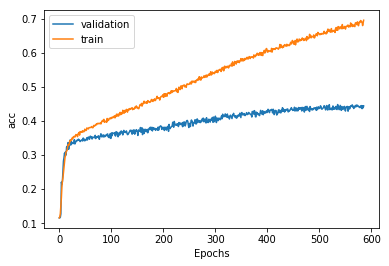

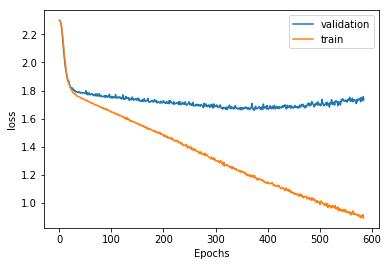


	Training model:
baseline
0 - U:512|A:relu|D:0.200 
1 - U:512|A:relu|D:0.200 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_____________________________________________________________

9600/9600 [==============================] - 0s 29us/step - loss: 1.6674 - acc: 0.3882 - val_loss: 1.7693 - val_acc: 0.3521
Epoch 51/50000
9600/9600 [==============================] - 0s 30us/step - loss: 1.6629 - acc: 0.3841 - val_loss: 1.7753 - val_acc: 0.3412
Epoch 52/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.6671 - acc: 0.3895 - val_loss: 1.7770 - val_acc: 0.3492
Epoch 53/50000
9600/9600 [==============================] - 0s 29us/step - loss: 1.6633 - acc: 0.3877 - val_loss: 1.7821 - val_acc: 0.3450
Epoch 54/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.6626 - acc: 0.3919 - val_loss: 1.7577 - val_acc: 0.3579
Epoch 55/50000
9600/9600 [==============================] - 0s 34us/step - loss: 1.6547 - acc: 0.3910 - val_loss: 1.7648 - val_acc: 0.3496
Epoch 56/50000
9600/9600 [==============================] - 0s 30us/step - loss: 1.6589 - acc: 0.3881 - val_loss: 1.7741 - val_acc: 0.3588
Epoch 57/50000
9600/9600 [================

Epoch 109/50000
9600/9600 [==============================] - 0s 32us/step - loss: 1.4516 - acc: 0.4773 - val_loss: 1.7716 - val_acc: 0.3788
Epoch 110/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.4515 - acc: 0.4734 - val_loss: 1.7467 - val_acc: 0.3796
Epoch 111/50000
9600/9600 [==============================] - 0s 30us/step - loss: 1.4487 - acc: 0.4727 - val_loss: 1.7370 - val_acc: 0.3683
Epoch 112/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4450 - acc: 0.4757 - val_loss: 1.7516 - val_acc: 0.3792
Epoch 113/50000
9600/9600 [==============================] - 0s 28us/step - loss: 1.4346 - acc: 0.4817 - val_loss: 1.7397 - val_acc: 0.3813
Epoch 114/50000
9600/9600 [==============================] - 0s 29us/step - loss: 1.4253 - acc: 0.4876 - val_loss: 1.7235 - val_acc: 0.3838
Epoch 115/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.4268 - acc: 0.4845 - val_loss: 1.8086 - val_acc: 0.3667
Epoch 116/50000
9600

9600/9600 [==============================] - 0s 30us/step - loss: 1.1199 - acc: 0.6101 - val_loss: 1.7861 - val_acc: 0.4100
Epoch 168/50000
9600/9600 [==============================] - 0s 29us/step - loss: 1.1219 - acc: 0.6026 - val_loss: 1.7506 - val_acc: 0.4121
Epoch 169/50000
9600/9600 [==============================] - 0s 29us/step - loss: 1.1177 - acc: 0.6097 - val_loss: 1.7750 - val_acc: 0.3958
Epoch 170/50000
9600/9600 [==============================] - 0s 35us/step - loss: 1.1129 - acc: 0.6095 - val_loss: 1.7949 - val_acc: 0.4025
Epoch 171/50000
9600/9600 [==============================] - 0s 33us/step - loss: 1.1023 - acc: 0.6144 - val_loss: 1.7868 - val_acc: 0.4108
Epoch 172/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.0993 - acc: 0.6160 - val_loss: 1.7836 - val_acc: 0.4217
Epoch 173/50000
9600/9600 [==============================] - 0s 31us/step - loss: 1.1016 - acc: 0.6101 - val_loss: 1.7726 - val_acc: 0.4071
Epoch 174/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 31us/step - loss: 0.8245 - acc: 0.7174 - val_loss: 1.8726 - val_acc: 0.4213
Epoch 226/50000
9600/9600 [==============================] - 0s 28us/step - loss: 0.8071 - acc: 0.7215 - val_loss: 1.8961 - val_acc: 0.4225
Epoch 227/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.7880 - acc: 0.7294 - val_loss: 1.9630 - val_acc: 0.4325
Epoch 228/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.8052 - acc: 0.7185 - val_loss: 1.9178 - val_acc: 0.4387
Epoch 229/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.7897 - acc: 0.7302 - val_loss: 1.9261 - val_acc: 0.4350
Epoch 230/50000
9600/9600 [==============================] - 0s 44us/step - loss: 0.7872 - acc: 0.7339 - val_loss: 1.9115 - val_acc: 0.4254
Epoch 231/50000
9600/9600 [==============================] - 0s 42us/step - loss: 0.7845 - acc: 0.7285 - val_loss: 1.9261 - val_acc: 0.4217
Epoch 232/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 34us/step - loss: 0.5941 - acc: 0.7985 - val_loss: 2.1391 - val_acc: 0.4400
Epoch 284/50000
9600/9600 [==============================] - 0s 49us/step - loss: 0.5917 - acc: 0.7975 - val_loss: 2.1057 - val_acc: 0.4387
Epoch 285/50000
9600/9600 [==============================] - 0s 32us/step - loss: 0.5674 - acc: 0.8034 - val_loss: 2.1169 - val_acc: 0.4458
Epoch 286/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.5861 - acc: 0.8008 - val_loss: 2.1451 - val_acc: 0.4308
Epoch 287/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.5861 - acc: 0.8025 - val_loss: 2.1296 - val_acc: 0.4329
Epoch 288/50000
9600/9600 [==============================] - 0s 30us/step - loss: 0.5711 - acc: 0.8025 - val_loss: 2.1784 - val_acc: 0.4400
Epoch 289/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.5598 - acc: 0.8068 - val_loss: 2.2872 - val_acc: 0.4200
Epoch 290/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 29us/step - loss: 0.4379 - acc: 0.8489 - val_loss: 2.4065 - val_acc: 0.4421
Epoch 342/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.4515 - acc: 0.8429 - val_loss: 2.4177 - val_acc: 0.4379
Epoch 343/50000
9600/9600 [==============================] - 0s 28us/step - loss: 0.4379 - acc: 0.8507 - val_loss: 2.3936 - val_acc: 0.4408
Epoch 344/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.4248 - acc: 0.8555 - val_loss: 2.4193 - val_acc: 0.4446
Epoch 345/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.4506 - acc: 0.8470 - val_loss: 2.4319 - val_acc: 0.4375
Epoch 346/50000
9600/9600 [==============================] - 0s 28us/step - loss: 0.4373 - acc: 0.8492 - val_loss: 2.4553 - val_acc: 0.4313
Epoch 347/50000
9600/9600 [==============================] - 0s 28us/step - loss: 0.4585 - acc: 0.8436 - val_loss: 2.4116 - val_acc: 0.4483
Epoch 348/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 28us/step - loss: 0.3621 - acc: 0.8781 - val_loss: 2.6709 - val_acc: 0.4271
Epoch 400/50000
9600/9600 [==============================] - 0s 33us/step - loss: 0.3724 - acc: 0.8695 - val_loss: 2.6061 - val_acc: 0.4325
Epoch 401/50000
9600/9600 [==============================] - 0s 32us/step - loss: 0.3552 - acc: 0.8784 - val_loss: 2.5947 - val_acc: 0.4404
Epoch 402/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.3720 - acc: 0.8741 - val_loss: 2.6122 - val_acc: 0.4304
Epoch 403/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.3560 - acc: 0.8753 - val_loss: 2.6925 - val_acc: 0.4229
Epoch 404/50000
9600/9600 [==============================] - 0s 29us/step - loss: 0.3455 - acc: 0.8798 - val_loss: 2.6459 - val_acc: 0.4379
Epoch 405/50000
9600/9600 [==============================] - 0s 28us/step - loss: 0.3654 - acc: 0.8772 - val_loss: 2.5623 - val_acc: 0.4358
Epoch 406/50000
9600/9600 [=========

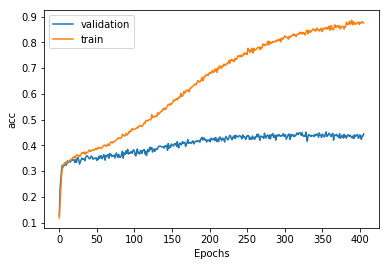

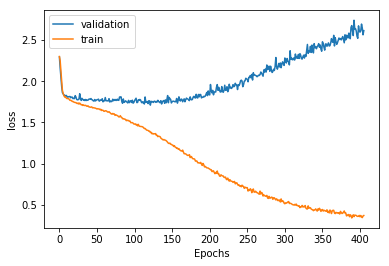


	Training model:
best
0 - U:830|A:prelu|D:0.654 
1 - U:782|A:tanh|D:0.166 
2 - U:28|A:elu|D:0.062 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 830)               651550    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 830)               830       
_________________________________________________________________
dropout_1 (Dropout)          (None, 830)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 782)               649842    
________________________________________

Epoch 47/50000
9600/9600 [==============================] - 0s 50us/step - loss: 1.7361 - acc: 0.3599 - val_loss: 1.7729 - val_acc: 0.3458
Epoch 48/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.7507 - acc: 0.3557 - val_loss: 1.7913 - val_acc: 0.3400
Epoch 49/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.7488 - acc: 0.3592 - val_loss: 1.7620 - val_acc: 0.3521
Epoch 50/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.7396 - acc: 0.3604 - val_loss: 1.7665 - val_acc: 0.3625
Epoch 51/50000
9600/9600 [==============================] - 0s 51us/step - loss: 1.7519 - acc: 0.3582 - val_loss: 1.7615 - val_acc: 0.3621
Epoch 52/50000
9600/9600 [==============================] - 0s 50us/step - loss: 1.7344 - acc: 0.3612 - val_loss: 1.7669 - val_acc: 0.3400
Epoch 53/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.7332 - acc: 0.3558 - val_loss: 1.7594 - val_acc: 0.3579
Epoch 54/50000
9600/9600 [=

Epoch 106/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.6508 - acc: 0.4026 - val_loss: 1.7373 - val_acc: 0.3596
Epoch 107/50000
9600/9600 [==============================] - 1s 53us/step - loss: 1.6443 - acc: 0.4000 - val_loss: 1.7258 - val_acc: 0.3721
Epoch 108/50000
9600/9600 [==============================] - 0s 50us/step - loss: 1.6510 - acc: 0.3980 - val_loss: 1.7278 - val_acc: 0.3787
Epoch 109/50000
9600/9600 [==============================] - 0s 51us/step - loss: 1.6491 - acc: 0.3943 - val_loss: 1.7387 - val_acc: 0.3708
Epoch 110/50000
9600/9600 [==============================] - 0s 47us/step - loss: 1.6474 - acc: 0.3997 - val_loss: 1.7260 - val_acc: 0.3746
Epoch 111/50000
9600/9600 [==============================] - 0s 47us/step - loss: 1.6382 - acc: 0.4002 - val_loss: 1.7346 - val_acc: 0.3713
Epoch 112/50000
9600/9600 [==============================] - 0s 44us/step - loss: 1.6339 - acc: 0.4034 - val_loss: 1.7258 - val_acc: 0.3733
Epoch 113/50000
9600

9600/9600 [==============================] - 0s 42us/step - loss: 1.5385 - acc: 0.4450 - val_loss: 1.7170 - val_acc: 0.3879
Epoch 165/50000
9600/9600 [==============================] - 0s 44us/step - loss: 1.5452 - acc: 0.4349 - val_loss: 1.6883 - val_acc: 0.3962
Epoch 166/50000
9600/9600 [==============================] - 0s 43us/step - loss: 1.5420 - acc: 0.4414 - val_loss: 1.6953 - val_acc: 0.3963
Epoch 167/50000
9600/9600 [==============================] - 0s 44us/step - loss: 1.5274 - acc: 0.4445 - val_loss: 1.7079 - val_acc: 0.3900
Epoch 168/50000
9600/9600 [==============================] - 0s 47us/step - loss: 1.5371 - acc: 0.4429 - val_loss: 1.6921 - val_acc: 0.3942
Epoch 169/50000
9600/9600 [==============================] - 0s 45us/step - loss: 1.5369 - acc: 0.4435 - val_loss: 1.7020 - val_acc: 0.3983
Epoch 170/50000
9600/9600 [==============================] - 0s 43us/step - loss: 1.5369 - acc: 0.4446 - val_loss: 1.7154 - val_acc: 0.3921
Epoch 171/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 48us/step - loss: 1.4371 - acc: 0.4858 - val_loss: 1.6857 - val_acc: 0.4029
Epoch 223/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.4336 - acc: 0.4866 - val_loss: 1.6782 - val_acc: 0.4079
Epoch 224/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.4147 - acc: 0.4918 - val_loss: 1.6953 - val_acc: 0.3954
Epoch 225/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.4200 - acc: 0.4855 - val_loss: 1.6964 - val_acc: 0.4042
Epoch 226/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.4221 - acc: 0.4916 - val_loss: 1.7028 - val_acc: 0.4083
Epoch 227/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.4174 - acc: 0.4945 - val_loss: 1.6656 - val_acc: 0.4129
Epoch 228/50000
9600/9600 [==============================] - 1s 53us/step - loss: 1.4322 - acc: 0.4820 - val_loss: 1.6668 - val_acc: 0.4150
Epoch 229/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 51us/step - loss: 1.3165 - acc: 0.5249 - val_loss: 1.6534 - val_acc: 0.4275
Epoch 281/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.3110 - acc: 0.5274 - val_loss: 1.6706 - val_acc: 0.4250
Epoch 282/50000
9600/9600 [==============================] - 0s 46us/step - loss: 1.3203 - acc: 0.5233 - val_loss: 1.6761 - val_acc: 0.4200
Epoch 283/50000
9600/9600 [==============================] - 1s 56us/step - loss: 1.3170 - acc: 0.5284 - val_loss: 1.6454 - val_acc: 0.4321
Epoch 284/50000
9600/9600 [==============================] - 1s 54us/step - loss: 1.2989 - acc: 0.5378 - val_loss: 1.6708 - val_acc: 0.4300
Epoch 285/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.3162 - acc: 0.5290 - val_loss: 1.6528 - val_acc: 0.4321
Epoch 286/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.2960 - acc: 0.5365 - val_loss: 1.6869 - val_acc: 0.4179
Epoch 287/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 44us/step - loss: 1.2183 - acc: 0.5651 - val_loss: 1.6791 - val_acc: 0.4463
Epoch 339/50000
9600/9600 [==============================] - 0s 43us/step - loss: 1.1954 - acc: 0.5683 - val_loss: 1.7114 - val_acc: 0.4383
Epoch 340/50000
9600/9600 [==============================] - 0s 43us/step - loss: 1.2051 - acc: 0.5748 - val_loss: 1.6690 - val_acc: 0.4408
Epoch 341/50000
9600/9600 [==============================] - 0s 44us/step - loss: 1.2108 - acc: 0.5655 - val_loss: 1.6897 - val_acc: 0.4317
Epoch 342/50000
9600/9600 [==============================] - 0s 44us/step - loss: 1.1897 - acc: 0.5710 - val_loss: 1.7133 - val_acc: 0.4233
Epoch 343/50000
9600/9600 [==============================] - 0s 45us/step - loss: 1.2004 - acc: 0.5675 - val_loss: 1.7034 - val_acc: 0.4325
Epoch 344/50000
9600/9600 [==============================] - 0s 44us/step - loss: 1.2074 - acc: 0.5695 - val_loss: 1.6859 - val_acc: 0.4379
Epoch 345/50000
9600/9600 [=========

9600/9600 [==============================] - 0s 47us/step - loss: 1.1231 - acc: 0.6005 - val_loss: 1.6780 - val_acc: 0.4412
Epoch 397/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.1146 - acc: 0.6071 - val_loss: 1.7127 - val_acc: 0.4392
Epoch 398/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.1144 - acc: 0.6023 - val_loss: 1.7234 - val_acc: 0.4417
Epoch 399/50000
9600/9600 [==============================] - 0s 49us/step - loss: 1.1191 - acc: 0.5964 - val_loss: 1.7105 - val_acc: 0.4342
Epoch 400/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.1172 - acc: 0.6001 - val_loss: 1.6994 - val_acc: 0.4367
Epoch 401/50000
9600/9600 [==============================] - 0s 48us/step - loss: 1.1114 - acc: 0.6035 - val_loss: 1.7197 - val_acc: 0.4496
Epoch 402/50000
9600/9600 [==============================] - 0s 45us/step - loss: 1.1047 - acc: 0.6017 - val_loss: 1.7099 - val_acc: 0.4504
Epoch 403/50000
9600/9600 [=========

In [ ]:
logreg = Cromosome([])
simplest = Cromosome([Layer(830, 'prelu', 0.654)])
baseline = Cromosome([Layer(512, 'relu', 0.2), Layer(512, 'relu', 0.2)])
best = Cromosome([Layer(830, 'prelu', 0.654), Layer(782, 'tanh', 0.166), Layer(28, 'elu', 0.062)])

models = {'logreg':logreg, 'simplest':simplest, 'baseline':baseline, 'best':best}
datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
results = {}

for dataset in datasets:
    print("-"*10 + "  DATASET %s  " % dataset + "-"*10)
    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=folder)
    data = dm.load_data()
    fitness = Fitness.get_instance()
    fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, 
                       epochs=epochs, early_stop=early_stop)
    for tag, model in models.items():
        if dataset != 'MRDBI' and tag!='logreg':
            continue
        print("\n\tTraining model:")
        print(tag)
        print(model, end='\n\n')
        score = model.fitness()
        results[(model.__repr__(), dataset)] = score